### Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

<b>Описание услуг</b>

Оператор предоставляет два основных типа услуг:

1.	Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.

2.	Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

<b>Также доступны такие услуги:</b>

•	Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);

•	Выделенная линия технической поддержки (TechSupport);

•	Облачное хранилище файлов для резервного копирования данных (OnlineBackup);

•	Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

<b>Описание данных</b>

Данные состоят из файлов, полученных из разных источников:

•	contract.csv — информация о договоре;

•	personal.csv — персональные данные клиента;

•	internet.csv — информация об интернет-услугах;

•	phone.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Данные
final_provider.zip

Данные также находятся в тренажёре, в папке /datasets/final_provider/.

<b>Данный проект будем выполнять в несколько этапов:</b>

[1. Загрузка и анализ данных](#step_1)

[2. Предобработка данных](#step_2)

[3. Обучение моделей ML и проверка их предсказаний по выбранным заранее метрикам](#step_3)

[4. Вывод о проделанной работе и рекомендации заказчику](#step_4)

## Загрузим необходимые библиотеки

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from scipy.stats import chi2_contingency
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve,\
    confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from xgboost.sklearn import XGBClassifier

In [3]:
import time
import optuna
from optuna.integration import OptunaSearchCV

In [4]:
import warnings
warnings.filterwarnings('ignore')

<a id=step_1></a>
## 1. Загрузка и анализ данных

Загрузим наши данные

In [5]:
df_names = 'contract', 'internet', 'personal', 'phone'
try:
    df_contract, df_internet, df_personal, df_phone =\
    (pd.read_csv(f'/datasets/final_provider/{name}.csv') for name in df_names)
except:
    df_contract, df_internet, df_personal, df_phone = \
        (pd.read_csv(f'{name}.csv') for name in df_names)

Напишем функцию для просмотра наших данных

In [6]:
def first_look (df: pd.DataFrame, limit_na_category: int = 10) -> None:
    '''Функция получения первичной информации о датафрейме'''
    print ('------------- Первые 5 строк ------------')
    display(df.head())
    print('')
    print('')
    print ('------------- Типы данных ------------')
    print (df.info())
    print('')
    print('')
    print ('------------- Пропуски ------------')
    count = 0
    shape_0 = df.shape[0]
    for element in df.columns:
        if df[element].isna().sum() > 0:
            print(element, ' - ', df[element].isna().sum(),\
                  'пропусков, ', round(df[element].isna().sum() * 100 / shape_0,2), '% от числа строк.' )
            count = +1
    if count == 0:
        print('Пропусков НЕТ')
        print('')
        print('')
    print ('------------- Дубликаты ------------')
    if df.duplicated().sum() > 0:
        print('Дубликатов: ', df.duplicated().sum())
    else:
        print('Дубликатов НЕТ')
    # ищем, есть ли категориальные столбцы (содержащие до limit_na_category уникальных значений) в датафрейме
    min_unique = limit_na_category + 1
    for element in df.columns:
        min_unique = min(min_unique, df[element].nunique())
        if min_unique <= limit_na_category:
            print('')
    print('')
    print('------------- Категориальные признаки ------------')
    for element in df.columns:
        if df[element].nunique() <= limit_na_category:
            print(element, ': ', df[element].nunique(), 'категории - ', df[element].unique(), )

Просмотрим наши данные

In [7]:
look = [df_contract, df_internet, df_personal, df_phone]

In [8]:
for i in look:
    first_look(i)

------------- Первые 5 строк ------------


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


------------- Пропуски ------------
Пропусков НЕТ


------------- Дубликаты ------------
Дубликатов НЕТ







------------- Категориальные признаки ------------
EndDate :  5 категории -  ['No' '2019-12-01 00:00:00' '2019-11-01 00:00:00' '2019-10-01 00:00:00'
 '2020-01-01 00:00:00']
Type :  3 категории -  ['Month-to-mont

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


------------- Пропуски ------------
Пропусков НЕТ


------------- Дубликаты ------------
Дубликатов НЕТ








------------- Категориальные признаки ------------
InternetService :  2 категории -  ['DSL' 'Fiber optic']
OnlineSecurity :  2 категории -  ['No' 'Yes']
OnlineBackup :  2 категории -  ['Yes' 'No']
DeviceProtection :  2 категории -  

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


------------- Пропуски ------------
Пропусков НЕТ


------------- Дубликаты ------------
Дубликатов НЕТ





------------- Категориальные признаки ------------
gender :  2 категории -  ['Female' 'Male']
SeniorCitizen :  2 категории -  [0 1]
Partner :  2 категории -  ['Yes' 'No']
Dependents :  2 категории -  ['No' 'Yes']
------------- Первые 5 строк ------------


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


------------- Пропуски ------------
Пропусков НЕТ


------------- Дубликаты ------------
Дубликатов НЕТ


------------- Категориальные признаки ------------
MultipleLines :  2 категории -  ['No' 'Yes']


<b>Таблица contract:</b>

Содержит 7043 записи, пропусков нет, дубликатов нет.

Столбец BeginDate имеет тип object, необходимо привести к типу дат.

Столбец EndDate имеет 5 категорий, необходимо привести к 'No', если клиент с нами.

<b>Таблица internet:</b>
Содержит 5517 записей, пропусков нет, дубликатов нет.

Все столбцы, исключая customerID - категорийные, в последующем их необходимо перекодировать.

<b>Таблица personal:</b>
Содержит 7043 записи, проусков нет, дубликатов нет.

Все столбцы, исключая customerID - категорийные, в последующем их необходимо перекодировать.

<b>Таблица phone:</b>
Содержит 6361 запись, пропусков нет, дубликатов нет.

Все столбцы, исключая customerID - категорийные, в последующем необходимо перекодировать

Проверим почему столбец TotalCharges имеет тип object, хотя должен иметь float

In [9]:
df_contract['TotalCharges'].sort_values().unique()

array([' ', '100.2', '100.25', ..., '999.45', '999.8', '999.9'],
      dtype=object)

Видим, что в значениях присутствует " ". Посмотрим внимательнее

In [10]:
df_contract[df_contract['TotalCharges'] == " "]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Все пропуски приходтся на BeginDate равное 2020-02-01. Посмотрим что еще приходится на данную дату

In [11]:


df_contract[df_contract['BeginDate'] == '2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Странно, обсолютно те же данные (один в один). Ок, скорее всего данные были выгружены в феврале 2020 года и на эту дату не было указано какую сумму платил обонент. Т.к. у нас есть несколько возможностей оплаты, а именно: 'Month-to-month' 'One year' 'Two year', то мы не сможем с уверенностью сказать, по какому принципу осуществлялся платеж, а следовательно не можем указать сумму.
Т.к. таких данных ничтожно мало, то мы их в последующем удалим.

Посмотрим на график ежемесячной оплаты и соотнесем его с уходом клиентов

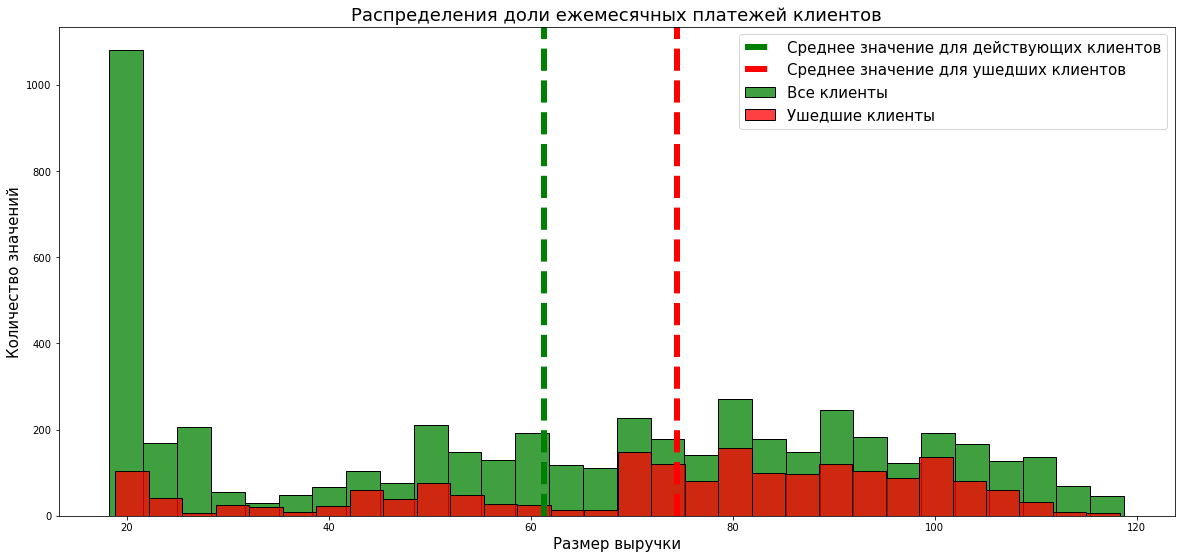

In [12]:

f, axes = plt.subplots(1, 1, figsize=(20, 9))
axes.set_title('Распределения доли ежемесячных платежей клиентов', fontsize=18)
axes.set_ylabel('Количество значений', fontsize=15)
sns.histplot(df_contract[df_contract['EndDate'] == 'No']['MonthlyCharges'], bins=30, color = 'green')
sns.histplot(df_contract[df_contract['EndDate'] != 'No']['MonthlyCharges'], bins = 30, color = 'red')
axes.set_xlabel('Размер выручки', fontsize=15)
plt.axvline(df_contract[df_contract['EndDate'] == 'No']['MonthlyCharges'].mean(), 0, color = 'green', linestyle='--', linewidth = 6)
plt.axvline(df_contract[df_contract['EndDate'] != 'No']['MonthlyCharges'].mean(), 0, color = 'red', linestyle='--', linewidth = 6)
axes.legend(labels=["Среднее значение для действующих клиентов","Среднее значение для ушедших клиентов", 
                    "Все клиенты","Ушедшие клиенты"], fontsize=15);

Из построенного графика наблюдаем, что от оператора уходят клиенты с большим среднемесячным платежом

На данном этапе мы загрузили данные, исследовали их. На следующем этапе произведем их предоработку для обучения моделей

<a id=step_2></a>
## 2. Предобработка данных

Для последующего исследования смерджим наши таблицы в одну

In [13]:
df = (df_personal
      .merge(df_contract, how="left", on="customerID")
      .merge(df_phone, how="left", on="customerID")
      .merge(df_internet, how="left", on="customerID"))

In [14]:
first_look(df)

------------- Первые 5 строк ------------


,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,No,Fiber optic,No,No,No,No,No,No




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           7043 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  D

Т.к. у нас появились пропуски в данных, причем именно в данных по подключенным услугам, можно сделать вывод, что пользователи ими не пользовались. Заменим пустые значения на 'No'

In [15]:


culumns_for_replase = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',\
                       'TechSupport', 'StreamingTV', 'StreamingMovies']
for i in culumns_for_replase:
    df[i] = df[i].fillna('No')

Столбцы, имеющие категориальные переменные преобразуем также

In [16]:
for i in df.select_dtypes('object').columns:
    if sorted(df[i].unique()) == ['No','Yes']:
        df[i] = (df[i] == 'Yes').astype('int')

Преобразуем также данные в столбце gender

In [17]:
 df['gender'] = (df['gender'] == 'Male').astype('int')

Заменил данные в столбце TotalCharges, обнаруженные ранее

In [18]:
df = df[df['TotalCharges'] != ' ']
df['TotalCharges'] = df['TotalCharges'].astype('float')

Создадим новый столбец target с нашим целевым признаком

In [19]:
df['target'] = (df['EndDate'] != 'No').astype('int')
df.loc[df['EndDate'] == 'No',  'EndDate'] = pd.to_datetime('2020-02-01 00:00:00')

Покажем наглядно влияние фичей на целевой признак - факт ухода клиента.

Для этого можно воспользоваться функцией chi2_contingency для определения статистической значимости различий ушедших и оставшихся клиентов.

Создадим функцию, принимающую на вход столбец, по которому будем считать корреляцию.

Функция мержит таблицу с количеством ушедших и оставшихся клиентов, сгруппированных по нужной фиче, вычисляет значение статистики и делает вывод о влиянии фичи на уход клиента из компании.

In [20]:
def merge_chi2(column):
    table_for_merge_1 = df.groupby(column, as_index = False)['target'].sum()
    table_for_merge_2 = df.groupby(column, as_index = False)['customerID'].count()
    merge_table = table_for_merge_1.merge(table_for_merge_2, on = column)
    merge_table.rename(columns = {'customerID':'all'}, inplace = True)
    merge_table['not_target'] = merge_table['all'] - merge_table['target']
    merge_table = merge_table.drop('all', axis = 1)
        
    stat, p_value, dof, expected = chi2_contingency(merge_table[['target', 'not_target']])
      
    return merge_table, p_value

Для наглядности добавил проверку гипотез.

Где:

нулевая гипотеза: признак не связан с оттоком клиентов;

альтернативная: признак связан с оттоком клиентов.

Примем значение порога статистической значимости alpha = 0.05.

Вызовем функцию для всех категориальных столбцов:

In [21]:
alpha = 0.05

,Type,target,not_target
0,Month-to-month,1655,2220
1,One year,166,1306
2,Two year,48,1637


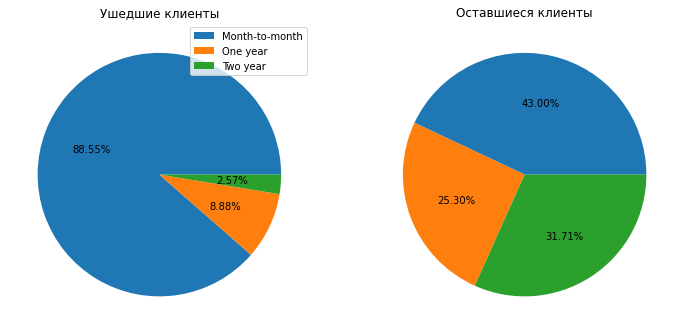

p-значение: 7.326182186264635e-257
Отклоняем нулевую гипотезу


,PaperlessBilling,target,not_target
0,0,469,2395
1,1,1400,2768


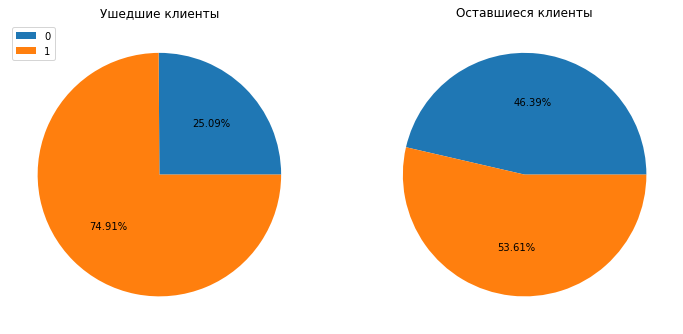

p-значение: 8.236203353962564e-58
Отклоняем нулевую гипотезу


,PaymentMethod,target,not_target
0,Bank transfer (automatic),258,1284
1,Credit card (automatic),232,1289
2,Electronic check,1071,1294
3,Mailed check,308,1296


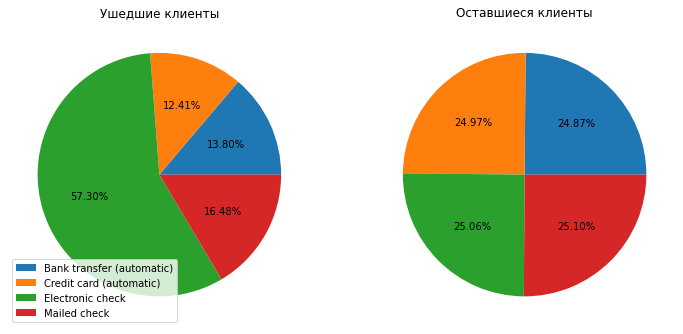

p-значение: 1.4263098511063342e-139
Отклоняем нулевую гипотезу


,gender,target,not_target
0,0,939,2544
1,1,930,2619


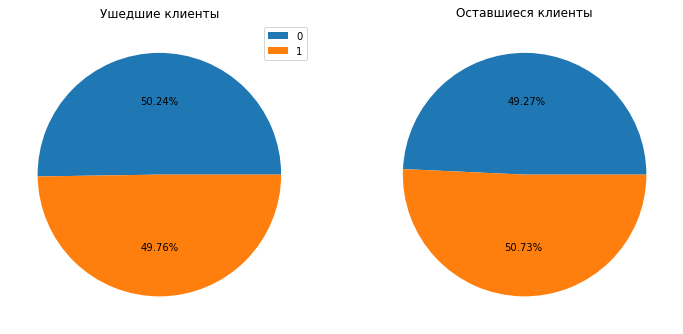

p-значение: 0.490488470706551
Не получилось отклонить нулевую гипотезу


,Partner,target,not_target
0,0,1200,2439
1,1,669,2724


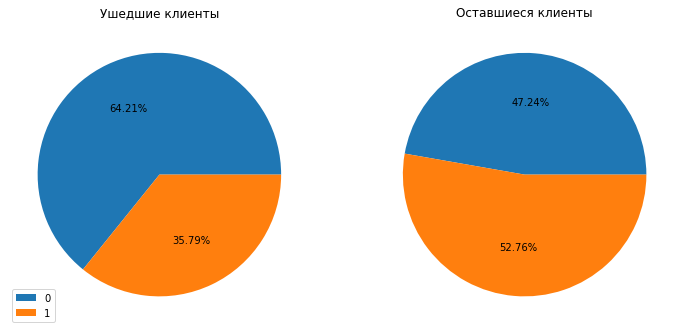

p-значение: 3.97379757451591e-36
Отклоняем нулевую гипотезу


,Dependents,target,not_target
0,0,1543,3390
1,1,326,1773


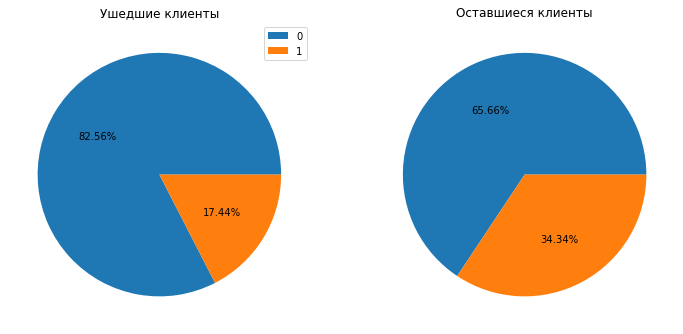

p-значение: 2.0196592017051303e-42
Отклоняем нулевую гипотезу


,SeniorCitizen,target,not_target
0,0,1393,4497
1,1,476,666


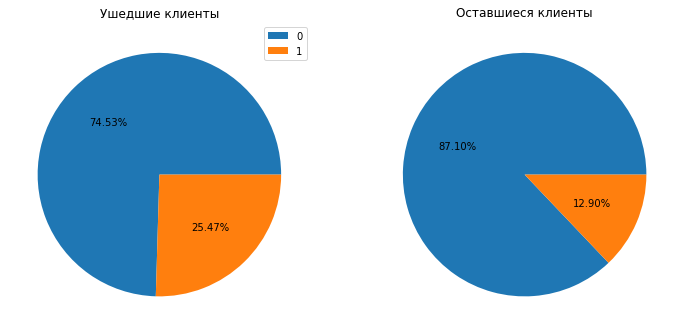

p-значение: 2.4792557203954705e-36
Отклоняем нулевую гипотезу


,InternetService,target,not_target
0,DSL,459,1957
1,Fiber optic,1297,1799
2,No,113,1407


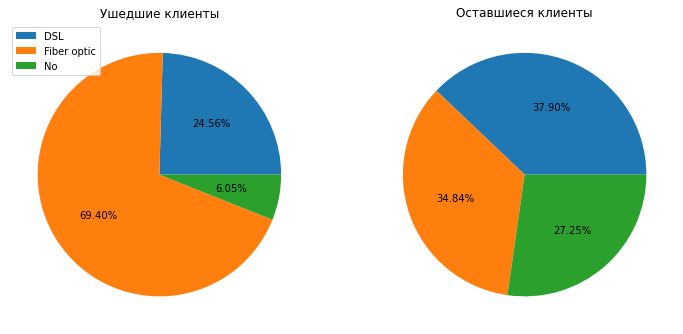

p-значение: 5.831198962237274e-159
Отклоняем нулевую гипотезу


,OnlineSecurity,target,not_target
0,0,1574,3443
1,1,295,1720


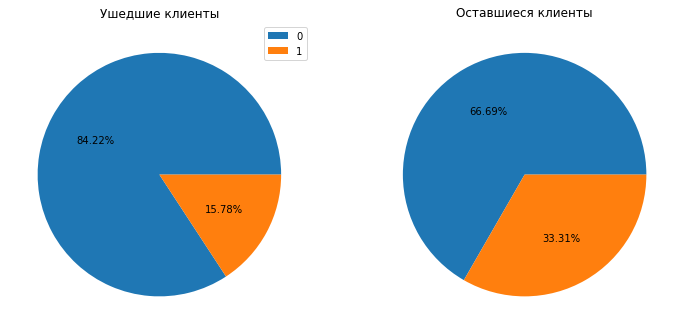

p-значение: 1.37424000884718e-46
Отклоняем нулевую гипотезу


,OnlineBackup,target,not_target
0,0,1346,3261
1,1,523,1902


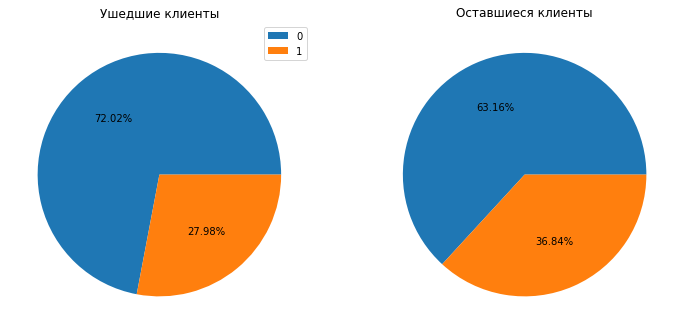

p-значение: 6.259257129714726e-12
Отклоняем нулевую гипотезу


,DeviceProtection,target,not_target
0,0,1324,3290
1,1,545,1873


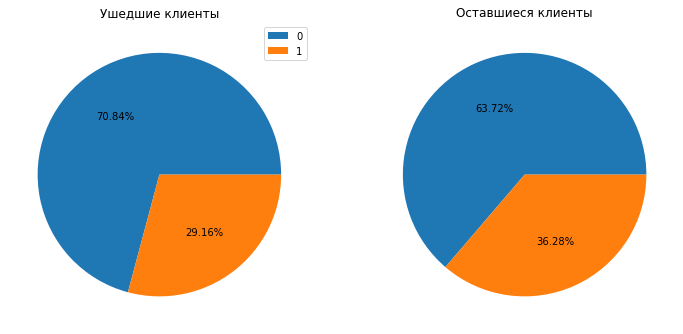

p-значение: 3.346074945648784e-08
Отклоняем нулевую гипотезу


,TechSupport,target,not_target
0,0,1559,3433
1,1,310,1730


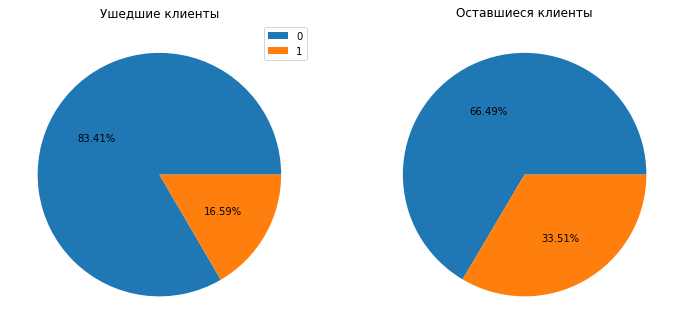

p-значение: 3.232868325549167e-43
Отклоняем нулевую гипотезу


,StreamingTV,target,not_target
0,0,1055,3274
1,1,814,1889


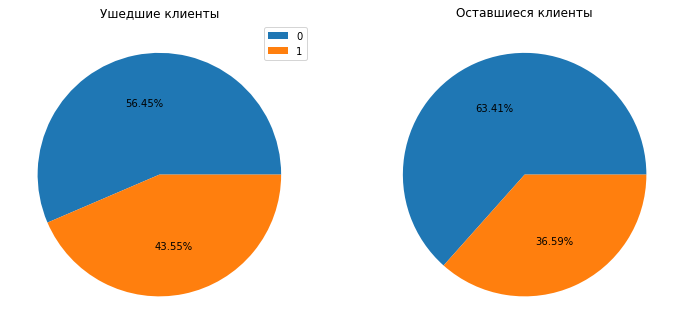

p-значение: 1.3164336109407092e-07
Отклоняем нулевую гипотезу


,StreamingMovies,target,not_target
0,0,1051,3250
1,1,818,1913


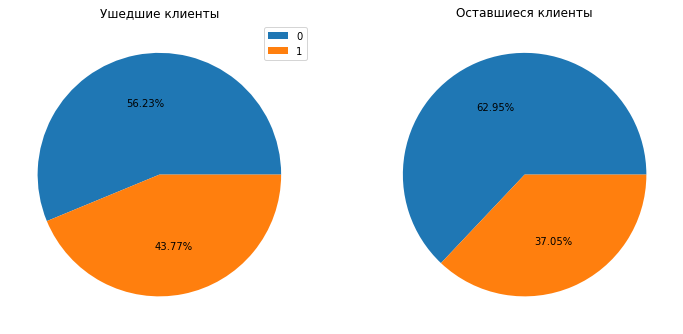

p-значение: 3.857900347663822e-07
Отклоняем нулевую гипотезу


,MultipleLines,target,not_target
0,0,1019,3046
1,1,850,2117


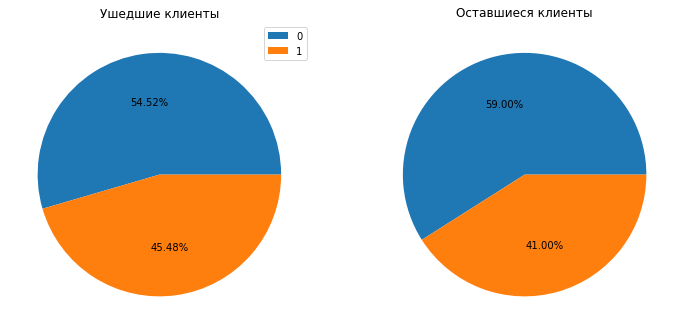

p-значение: 0.0008694082815826175
Отклоняем нулевую гипотезу


In [22]:
category_columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents',\
                    'SeniorCitizen', 'InternetService', 'OnlineSecurity', 'OnlineBackup',\
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

for i in category_columns:
    table_on_chi2, p_value = merge_chi2(i)
    display(table_on_chi2)
    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 2, 1)
    plt.pie(table_on_chi2['target'], autopct='%1.2f%%')
    plt.legend(labels=table_on_chi2[i], loc='best')
    plt.title('Ушедшие клиенты')
   
    
    plt.subplot(1, 2, 2)
    plt.pie(table_on_chi2['not_target'], autopct='%1.2f%%')
    plt.title('Оставшиеся клиенты')
    plt.show()
    print('p-значение:', p_value)
    if p_value < alpha:
        print('Отклоняем нулевую гипотезу')
    else:
        print('Не получилось отклонить нулевую гипотезу')

По сути дела не получилось отклонить нулевую гипотезу только по признаку gender.
Удалим его из фичей, так как он неинформативен.

Из таблицы способа оплаты мы видим, что больше всего уходят клиенты с оплатой помесячно.

Из таблиц способов расчета и способов оплаты - больше уходят клиентов с безналичной оплатой по электронным платежам.

Из таблицы наличия супруга (супруги) - больше уходят одиночки.

Из таблицы наличия иждивенцев - больше уходят одиночки.

Из таблицы пенсионного статуса - больше уходят непенсионного возраста.

Из таблицы интернета - больше всего уходят подключенные по оптики (возможно данное подключение дорогое либо качество услуг не устраивает).

Из таблицы подключенных услуг онлайн защиты (фаервола, антивируса) - больше уходят не пользующиеся данной услугой.

Из таблицы подключенных услуг онлайн сохранения - больше уходят не пользующиеся данной услугой.

Из таблицы подключенных услуг DeviceProtection - больше уходят не пользующиеся данной услугой.

Из таблицы подключенных услуг TechSupport - больше уходят не пользующиеся данной услугой.

Из таблицы подключенных услуг StreamingTV - больше уходят не пользующиеся данной услугой.

Из таблицы подключенных услуг StreamingMovies - больше уходят не пользующиеся данной услугой.

Можно сконструировать социальный портрет абонента с высоким риском отказа от услуг компании:

это абонент, не состоящий в браке, не имеющий иждивенцев (детей, престарелых родителей, инвалидов), не достигший пенсионного возраста, заключивший договор недавно, оплачивающий услуги с безналичной оплатой электронными чеками помесячно, имеющий подключение по оптоволоконной связи и не подключающий услуги онлайн-защиты, не пользующийся предлагаемыми дополнительными услугами связи.

Из предыдущего анализа попытаемся понять как влияет срок подключения к риску ухода абонента

Создадим новый столбец days с новым признаком и удалим далее не нужные столбцы BeginDate, customerID, gender и EndDate

In [23]:
df['days'] =  (pd.to_datetime(df['EndDate']) - pd.to_datetime(df['BeginDate'])).dt.days
df = df.drop(['customerID', 'BeginDate', 'gender', 'EndDate'], axis=1)

In [24]:
first_look(df)

------------- Первые 5 строк ------------


,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,target,days
0,0,1,0,Month-to-month,1,Electronic check,29.85,29.85,0,DSL,0,1,0,0,0,0,0,31
1,0,0,0,One year,0,Mailed check,56.95,1889.50,0,DSL,1,0,1,0,0,0,0,1036
2,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,0,DSL,1,1,0,0,0,0,1,61
3,0,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,DSL,1,0,1,1,0,0,0,1371
4,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,0,Fiber optic,0,0,0,0,0,0,1,61




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     7032 non-null   int64  
 1   Partner           7032 non-null   int32  
 2   Dependents        7032 non-null   int32  
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   int32  
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   MultipleLines     7032 non-null   int32  
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   int32  
 11  OnlineBackup      7032 non-null   int32  
 12  DeviceProtection  7032 non-null   int32  
 13  TechSupport       7032 non-null   int32  
 14  StreamingTV       7032 non-null   int32  
 15  StreamingMovies   7032 non-null   int32  
 16  t

Посмотрим распределение ушедших клинетов.

0    0.734215
1    0.265785
Name: target, dtype: float64


<AxesSubplot:title={'center':'График количества ушедших к оставшимся клиентам'}>

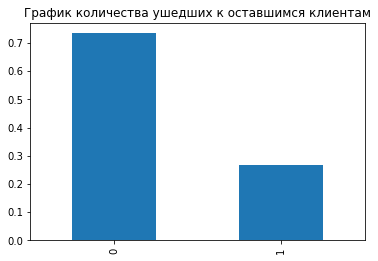

In [25]:
class_frequency = df ['target'].value_counts (normalize = bool)
print (class_frequency)
class_frequency.plot (kind = 'bar', title = 'График количества ушедших к оставшимся клиентам')

Наблюдаем явный дисбаланс классов

Проверим наши данные на корреляцию

In [26]:
df[['MonthlyCharges', 'TotalCharges', 'days']].corr()

,MonthlyCharges,TotalCharges,days
MonthlyCharges,1.000000,0.651065,0.246715
TotalCharges,0.651065,1.000000,0.825811
days,0.246715,0.825811,1.000000


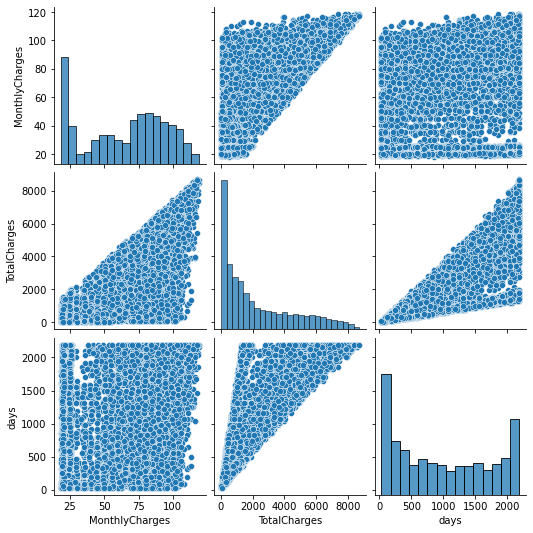

In [27]:
sns.pairplot(df[['MonthlyCharges', 'TotalCharges', 'days']])

Попробуем удалить из наших данных столбец TotalCharges, т.к. он очень сильно коррелирует с днями жизни договора пользователя

In [28]:
df = df.drop(labels = ['TotalCharges'], axis = 1)

In [29]:
first_look(df)

------------- Первые 5 строк ------------


,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,target,days
0,0,1,0,Month-to-month,1,Electronic check,29.85,0,DSL,0,1,0,0,0,0,0,31
1,0,0,0,One year,0,Mailed check,56.95,0,DSL,1,0,1,0,0,0,0,1036
2,0,0,0,Month-to-month,1,Mailed check,53.85,0,DSL,1,1,0,0,0,0,1,61
3,0,0,0,One year,0,Bank transfer (automatic),42.30,0,DSL,1,0,1,1,0,0,0,1371
4,0,0,0,Month-to-month,1,Electronic check,70.70,0,Fiber optic,0,0,0,0,0,0,1,61




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     7032 non-null   int64  
 1   Partner           7032 non-null   int32  
 2   Dependents        7032 non-null   int32  
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   int32  
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   MultipleLines     7032 non-null   int32  
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   int32  
 10  OnlineBackup      7032 non-null   int32  
 11  DeviceProtection  7032 non-null   int32  
 12  TechSupport       7032 non-null   int32  
 13  StreamingTV       7032 non-null   int32  
 14  StreamingMovies   7032 non-null   int32  
 15  target            7032 non-null   int32  
 16  d

На данном этапе мы подготовили наши данные для последующего обучения моделями. На следующем этапе приступим к обучению моделями

<a id=step_3></a>
## 3. Обучение моделей ML и проверка их предсказаний по выбранным заранее метрикам

Для корректной работы модели логистической регрессии необходимо наши данные перекодировать методом унитарного кодирования (One Hot Encoding)

In [30]:
df_ohe = df.copy()
df_ohe = pd.get_dummies(df, drop_first=True)

In [31]:
first_look(df_ohe)

------------- Первые 5 строк ------------


,SeniorCitizen,Partner,Dependents,PaperlessBilling,MonthlyCharges,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,StreamingMovies,target,days,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No
0,0,1,0,1,29.85,0,0,1,0,0,...,0,0,31,0,0,0,1,0,0,0
1,0,0,0,0,56.95,0,1,0,1,0,...,0,0,1036,1,0,0,0,1,0,0
2,0,0,0,1,53.85,0,1,1,0,0,...,0,1,61,0,0,0,0,1,0,0
3,0,0,0,0,42.30,0,1,0,1,1,...,0,0,1371,1,0,0,0,0,0,0
4,0,0,0,1,70.70,0,0,0,0,0,...,0,1,61,0,0,0,1,0,1,0




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7032 non-null   int64  
 1   Partner                                7032 non-null   int32  
 2   Dependents                             7032 non-null   int32  
 3   PaperlessBilling                       7032 non-null   int32  
 4   MonthlyCharges                         7032 non-null   float64
 5   MultipleLines                          7032 non-null   int32  
 6   OnlineSecurity                         7032 non-null   int32  
 7   OnlineBackup                           7032 non-null   int32  
 8   DeviceProtection                       7032 non-null   int32  
 9   TechSupport                            7032 non-null   int32  
 10  StreamingTV                    

Выделим фичи и целевой признак

In [32]:
features_lr = df_ohe.drop('target', axis=1)
target_lr = df_ohe['target']

Создадим из нашего датасета две выборки для корректной работы.

Датасет df_train, состоящий из 75% общих данных для обучения модели

Датасет df_test, состоящий из 25% общих данных для конечной проверки работоспособности модели

In [33]:
features_train_lr, features_test_lr, target_train_lr, target_test_lr = train_test_split (
    features_lr, target_lr, test_size = 0.25, random_state = 12345)

Поборемся с дисбалансов классов методом увеличения выборки по ушедшим пользователям

In [34]:
def upsample (features, target, repeat):
    #разделим выборку по значениям целевых показателей
    target_one = target [target == 1]
    target_zero = target [target == 0]
    features_one = features [target ==1]
    features_zero  = features [target == 0]
    
    #увеличим и соединим обратно
    features_upsample = pd.concat ([features_zero] + [features_one] * repeat)
    target_upsample = pd.concat ([target_zero] + [target_one] * repeat)
    
    #перемешаем для более точного результата
    features_upsample, target_upsample = shuffle (features_upsample, target_upsample, random_state = 12345)
    
    return features_upsample, target_upsample

In [35]:
features_upsample_lr, target_upsample_lr = upsample (features_train_lr, target_train_lr, 3)

features_zero = features_upsample_lr [target_upsample_lr == 0]
features_one = features_upsample_lr [target_upsample_lr == 1]

print(features_zero.shape[0])
print(features_one.shape[0])

3870
4212


In [36]:
display(features_upsample_lr.shape)
display(features_test_lr.shape)

display(target_upsample_lr.shape)
display(target_test_lr.shape)

(8082, 20)

(1758, 20)

(8082,)

(1758,)

Т.к. в столбцах MonthlyCharges, days и TotalCharges присутствуют числовые признаки, нормализуим эти данные

In [37]:
numeric = ['MonthlyCharges', 'days']

scaler = StandardScaler()
scaler.fit(features_upsample_lr[numeric])

features_upsample_lr[numeric] = scaler.transform(features_upsample_lr[numeric])
features_test_lr[numeric] = scaler.transform(features_test_lr[numeric])

features_upsample_lr.head()

,SeniorCitizen,Partner,Dependents,PaperlessBilling,MonthlyCharges,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,days,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No
1621,0,0,0,1,0.637200,1,0,0,0,0,1,0,0.305534,0,0,0,1,0,1,0
5686,1,0,0,1,0.591817,0,1,0,0,0,1,0,-0.896508,0,0,0,0,0,1,0
6146,0,0,0,1,1.092781,0,0,1,1,0,1,1,-0.108351,0,0,0,1,0,1,0
1686,0,1,1,1,-0.284435,1,0,1,0,1,0,0,-0.067372,0,0,0,1,0,0,0
6151,0,0,0,0,0.097834,0,0,0,0,0,0,0,-0.774938,0,0,0,1,0,1,0


Для модели LGBMClassifier переведем значения категориальных признаков в тип category

In [38]:
category_columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Partner', 'Dependents', 'SeniorCitizen',\
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',\
                    'StreamingTV', 'StreamingMovies', 'MultipleLines']
df_lgbm = df.copy()
for i in category_columns:
    df_lgbm[i] = df_lgbm[i].astype('category')

In [39]:
first_look(df_lgbm)

------------- Первые 5 строк ------------


,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,target,days
0,0,1,0,Month-to-month,1,Electronic check,29.85,0,DSL,0,1,0,0,0,0,0,31
1,0,0,0,One year,0,Mailed check,56.95,0,DSL,1,0,1,0,0,0,0,1036
2,0,0,0,Month-to-month,1,Mailed check,53.85,0,DSL,1,1,0,0,0,0,1,61
3,0,0,0,One year,0,Bank transfer (automatic),42.30,0,DSL,1,0,1,1,0,0,0,1371
4,0,0,0,Month-to-month,1,Electronic check,70.70,0,Fiber optic,0,0,0,0,0,0,1,61




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   SeniorCitizen     7032 non-null   category
 1   Partner           7032 non-null   category
 2   Dependents        7032 non-null   category
 3   Type              7032 non-null   category
 4   PaperlessBilling  7032 non-null   category
 5   PaymentMethod     7032 non-null   category
 6   MonthlyCharges    7032 non-null   float64 
 7   MultipleLines     7032 non-null   category
 8   InternetService   7032 non-null   category
 9   OnlineSecurity    7032 non-null   category
 10  OnlineBackup      7032 non-null   category
 11  DeviceProtection  7032 non-null   category
 12  TechSupport       7032 non-null   category
 13  StreamingTV       7032 non-null   category
 14  StreamingMovies   7032 non-null   category
 15  target            7032 non-null

Так же разделим выборку для модели LGBMClassifier

In [40]:
target_lgbm = df_ohe['target']
features_lgbm = df_ohe.drop('target', axis=1)

features_train_lgbm, features_test_lgbm, target_train_lgbm, target_test_lgbm = train_test_split(
                                      features_lgbm, target_lgbm, test_size=0.25, random_state = 12345)

display(features_train_lgbm.shape)
display(features_test_lgbm.shape)

(5274, 20)

(1758, 20)

In [41]:
first_look(features_train_lgbm)

------------- Первые 5 строк ------------


,SeniorCitizen,Partner,Dependents,PaperlessBilling,MonthlyCharges,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,days,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No
5495,0,0,0,1,73.85,0,0,0,0,1,0,0,335,0,0,0,1,0,1,0
2009,0,1,1,1,79.25,1,1,1,1,1,1,0,2132,0,1,0,0,0,0,0
1800,0,0,0,1,43.85,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0
5630,0,0,0,1,103.45,1,0,1,1,0,1,1,1187,0,0,0,1,0,1,0
6295,0,1,1,0,20.20,0,0,0,0,0,0,0,1461,0,1,0,0,0,0,1




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 5495 to 4586
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          5274 non-null   int64  
 1   Partner                                5274 non-null   int32  
 2   Dependents                             5274 non-null   int32  
 3   PaperlessBilling                       5274 non-null   int32  
 4   MonthlyCharges                         5274 non-null   float64
 5   MultipleLines                          5274 non-null   int32  
 6   OnlineSecurity                         5274 non-null   int32  
 7   OnlineBackup                           5274 non-null   int32  
 8   DeviceProtection                       5274 non-null   int32  
 9   TechSupport                            5274 non-null   int32  
 10  StreamingTV                 

Т.к. в столбцах MonthlyCharges, days и TotalCharges присутствуют числовые признаки, нормализуим эти данные

In [42]:
numeric = ['MonthlyCharges', 'days']
scaler.fit(features_train_lgbm[numeric])

features_train_lgbm[numeric] = scaler.transform(features_train_lgbm[numeric])
features_test_lgbm[numeric] = scaler.transform(features_test_lgbm[numeric])

In [43]:
first_look(features_train_lgbm)

------------- Первые 5 строк ------------


,SeniorCitizen,Partner,Dependents,PaperlessBilling,MonthlyCharges,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,days,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No
5495,0,0,0,1,0.296184,0,0,0,0,1,0,0,-0.878490,0,0,0,1,0,1,0
2009,0,1,1,1,0.475876,1,1,1,1,1,1,0,1.521473,0,1,0,0,0,0,0
1800,0,0,0,1,-0.702104,0,0,0,0,0,0,0,-1.284493,0,0,0,0,0,0,0
5630,0,0,0,1,1.281161,1,0,1,1,0,1,1,0.259389,0,0,0,1,0,1,0
6295,0,1,1,0,-1.489087,0,0,0,0,0,0,0,0.625327,0,1,0,0,0,0,1




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 5495 to 4586
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          5274 non-null   int64  
 1   Partner                                5274 non-null   int32  
 2   Dependents                             5274 non-null   int32  
 3   PaperlessBilling                       5274 non-null   int32  
 4   MonthlyCharges                         5274 non-null   float64
 5   MultipleLines                          5274 non-null   int32  
 6   OnlineSecurity                         5274 non-null   int32  
 7   OnlineBackup                           5274 non-null   int32  
 8   DeviceProtection                       5274 non-null   int32  
 9   TechSupport                            5274 non-null   int32  
 10  StreamingTV                 

Т.к. в столбцах MonthlyCharges, days и TotalCharges присутствуют числовые признаки, нормализуим эти данные

In [44]:
features_train_lgbm_upsample, target_train_lgbm_upsample = upsample (features_train_lgbm, target_train_lgbm, 3)

features_zero = features_train_lgbm_upsample [target_upsample_lr == 0]
features_one = features_train_lgbm_upsample [target_upsample_lr == 1]

print(features_zero.shape[0])
print(features_one.shape[0])

3870
4212


Проделаем тоже и для других модлей

In [45]:
features = df_ohe.drop('target', axis=1)
target = df_ohe['target']

In [46]:
features_train, features_test, target_train, target_test = train_test_split (
    features, target, test_size = 0.25, random_state = 12345)

In [47]:
first_look(features_train)

------------- Первые 5 строк ------------


,SeniorCitizen,Partner,Dependents,PaperlessBilling,MonthlyCharges,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,days,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No
5495,0,0,0,1,73.85,0,0,0,0,1,0,0,335,0,0,0,1,0,1,0
2009,0,1,1,1,79.25,1,1,1,1,1,1,0,2132,0,1,0,0,0,0,0
1800,0,0,0,1,43.85,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0
5630,0,0,0,1,103.45,1,0,1,1,0,1,1,1187,0,0,0,1,0,1,0
6295,0,1,1,0,20.20,0,0,0,0,0,0,0,1461,0,1,0,0,0,0,1




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 5495 to 4586
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          5274 non-null   int64  
 1   Partner                                5274 non-null   int32  
 2   Dependents                             5274 non-null   int32  
 3   PaperlessBilling                       5274 non-null   int32  
 4   MonthlyCharges                         5274 non-null   float64
 5   MultipleLines                          5274 non-null   int32  
 6   OnlineSecurity                         5274 non-null   int32  
 7   OnlineBackup                           5274 non-null   int32  
 8   DeviceProtection                       5274 non-null   int32  
 9   TechSupport                            5274 non-null   int32  
 10  StreamingTV                 

In [48]:
numeric = ['MonthlyCharges', 'days']
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [49]:
features_train_upsample, target_train_upsample = upsample (features_train, target_train, 3)

features_zero = features_train_upsample [target_train_upsample == 0]
features_one = features_train_upsample [target_train_upsample == 1]

print(features_zero.shape[0])
print(features_one.shape[0])

3870
4212


Создадим функцию обучения модели с поиском оптимальных параметров

In [50]:
def tuning_optuna_cv(model, features, target, params=None, cv=5, timeseries_cv=0, n_trials=10,\
                     scoring=None, random_state=None, get_time=False):
    """
    model - модель на вход
    features - признаки
    target - целевой признак
    params - словарь параметров (должен быть заточен под оптюновский интерфейс)
    cv - количество подвыборок для кросс-валидации
    timeseries_cv - для временных рядов, количество подвыборок для кросс-валидации
    n_trials - количество проводимых экспериментов для поиска гиперпараметров
    scoring - метрика, на основе которой будут подбираться гиперпараметры модели; если не указана,
                используется встроенная в модель метрика
                (см. https://scikit-learn.org/stable/modules/model_evaluation.html)
    get_time - получение затраченного времени на подбор гиперпараметров в минутах
    
    """
    opt_distr_int = optuna.distributions.IntUniformDistribution
    opt_distr_float = optuna.distributions.LogUniformDistribution
    
    if timeseries_cv >= 2:
        cv = TimeSeriesSplit(n_splits=timeseries_cv)
        
    if get_time == True:
        start_time = time.time()
    
    if (type(model).__name__ == 'DecisionTreeRegressor' or 
        type(model).__name__ == 'DecisionTreeClassifier'):
        
        param_distributions = {
            'min_samples_leaf':opt_distr_int(2,50),
            'min_samples_split':opt_distr_int(2,200),
            'max_depth':opt_distr_int(1,50)
        }
        
        if params != None:
            param_distributions = params
        
        optuna_search = OptunaSearchCV(
            model, param_distributions, cv=cv,
            n_trials=n_trials, scoring=scoring,
            random_state=random_state
        )
        optuna_search.fit(features, target)
    
        best_model = optuna_search.best_estimator_
        
        print(f'Подобранные параметры модели: {optuna_search.best_params_}\n')
        print(f'Полученная метрика: {round(optuna_search.best_score_, 2)}\n')
        
        if get_time == True:
            end_time = time.time() - start_time
            print(f'Затраченное время на подбор: {end_time/60:.2f} мин')
        
        return best_model, optuna_search.best_params_, round(optuna_search.best_score_, 2)
    
    if (type(model).__name__ == 'RandomForestRegressor' or 
        type(model).__name__ == 'RandomForestClassifier'):
        
        param_distributions = {
            'n_estimators':opt_distr_int(50,200),
            'min_samples_split':opt_distr_int(2,25),
            'max_depth':opt_distr_int(1,50),
            'min_samples_leaf':opt_distr_int(2,25)
        }
        
        if params != None:
            param_distributions = params
        
        optuna_search = OptunaSearchCV(
            model, param_distributions, cv=cv,
            n_trials=n_trials, scoring=scoring,
            random_state=random_state
        )
        optuna_search.fit(features, target)
    
        best_model = optuna_search.best_estimator_
        
        print(f'Подобранные параметры модели: {optuna_search.best_params_}\n')
        print(f'Полученная метрика: {round(optuna_search.best_score_, 2)}\n')
        
        if get_time == True:
            end_time = time.time() - start_time
            print(f'Затраченное время на подбор: {end_time/60:.2f} мин')
            
        return best_model, optuna_search.best_params_, round(optuna_search.best_score_, 2)
    
    if (type(model).__name__ == 'CatBoostRegressor' or 
        type(model).__name__ == 'CatBoostClassifier'):
        
        param_distributions = {
            'iterations':opt_distr_int(10,300),
            'learning_rate':opt_distr_float(0.01,1.0),
            'depth':opt_distr_int(1,10)
        }
        
        if params != None:
            param_distributions = params
        
        optuna_search = OptunaSearchCV(
            model, param_distributions, cv=cv,
            n_trials=n_trials, scoring=scoring,
            random_state=random_state
        )
        optuna_search.fit(features, target)
    
        best_model = optuna_search.best_estimator_
        
        print(f'Подобранные параметры модели: {optuna_search.best_params_}\n')
        print(f'Полученная метрика: {round(optuna_search.best_score_, 2)}\n')
        
        if get_time == True:
            end_time = time.time() - start_time
            print(f'Затраченное время на подбор: {end_time/60:.2f} мин')
            
        return best_model, optuna_search.best_params_, round(optuna_search.best_score_, 2)
    
    if (type(model).__name__ == 'LGBMRegressor' or 
        type(model).__name__ == 'LGBMClassifier'):
        
        param_distributions = {
            'n_estimators':opt_distr_int(10,300),
            'learning_rate':opt_distr_float(0.01,1.0),
            'max_depth':opt_distr_int(1,16)
        }
        
        if params != None:
            param_distributions = params
        
        optuna_search = OptunaSearchCV(
            model, param_distributions, cv=cv,
            n_trials=n_trials, scoring=scoring,
            random_state=random_state
        )
        optuna_search.fit(features, target)
    
        best_model = optuna_search.best_estimator_
        
        print(f'Подобранные параметры модели: {optuna_search.best_params_}\n')
        print(f'Полученная метрика: {round(optuna_search.best_score_, 2)}\n')
        
        if get_time == True:
            end_time = time.time() - start_time
            print(f'Затраченное время на подбор: {end_time/60:.2f} мин')
            
        return best_model, optuna_search.best_params_, round(optuna_search.best_score_, 2)
    
    else:
        if timeseries_cv >= 2:
            cv = TimeSeriesSplit(n_splits=timeseries_cv)
        
        if get_time == True:
            start_time = time.time()
    
        optuna_search = OptunaSearchCV(model, params, cv=cv, n_trials=n_trials, scoring=scoring,\
                                       random_state=random_state)
        optuna_search.fit(features, target)
    
        best_model = optuna_search.best_estimator_
        
        print(f'Подобранные параметры модели: {optuna_search.best_params_}\n')
        print(f'Полученная метрика: {round(optuna_search.best_score_, 2)}\n')
        
        if get_time == True:
            end_time = time.time() - start_time
            print(f'Затраченное время на подбор: {end_time/60:.2f} мин')
        
        return best_model, optuna_search.best_params_, round(optuna_search.best_score_, 2)

Т.к. заказчику важна метрика ROC-AUC, то и будем на нее ориентироваться в наших расчетах, но нам также важны и остальные метрики, такие как Accuracy. Кроме того, важными параметрами являются время обучения и время предсказания модели. Создадим функцию model_final, принимающую на вход обученную модель, ее обучающие и тестовые выборки. На выходе - требуемые метрики, а также время обучения и время предсказания модели.

In [51]:
def model_final(model, features_train, target_train, features_test, target_test):
    start = time.time()    
    model.fit(features_train, target_train)
    train_time = time.time() - start
    
    start = time.time()  
    target_pred = model.predict(features_test)
    predict_time = time.time() - start
    
    roc_auc = roc_auc_score(target_test, model.predict_proba(features_test)[:,1])
    accuracy = accuracy_score(target_test, target_pred)
    precision = precision_score(target_test, target_pred)
    recall = recall_score(target_test, target_pred)

    return train_time, predict_time, roc_auc, accuracy, precision, recall

Найдем наилучшие значения гиперпараметров для логистической регрессии с наилучшим результатом точночти прогноза

In [52]:
parameters =  {
    'C': optuna.distributions.LogUniformDistribution(1e-7, 10.0),
    'solver': optuna.distributions.CategoricalDistribution(("lbfgs", "saga")),
}
best_model_LogisticRegression, best_params, best_score = tuning_optuna_cv(
    LogisticRegression(), features_upsample_lr, target_upsample_lr, params=parameters, cv=5, timeseries_cv=0, n_trials=10,\
    scoring='roc_auc', random_state=12345, get_time=False)

[I 2022-07-26 12:27:57,881] A new study created in memory with name: no-name-f3bc97ea-5100-4efe-b3d9-241bd5344b71
[I 2022-07-26 12:27:58,121] Trial 0 finished with value: 0.8418580952144431 and parameters: {'C': 0.1292550302105891, 'solver': 'saga'}. Best is trial 0 with value: 0.8418580952144431.
[I 2022-07-26 12:27:58,214] Trial 1 finished with value: 0.8326348897705508 and parameters: {'C': 8.626130493668947e-07, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8418580952144431.
[I 2022-07-26 12:27:58,454] Trial 2 finished with value: 0.8413657351845767 and parameters: {'C': 0.07327671532110211, 'solver': 'saga'}. Best is trial 0 with value: 0.8418580952144431.
[I 2022-07-26 12:27:58,671] Trial 3 finished with value: 0.83360707920185 and parameters: {'C': 0.00030883863609133496, 'solver': 'saga'}. Best is trial 0 with value: 0.8418580952144431.
[I 2022-07-26 12:27:58,750] Trial 4 finished with value: 0.8340580387576294 and parameters: {'C': 0.0005148938132715633, 'solver': 'lbfgs'}

Подобранные параметры модели: {'C': 1.9346628120616662, 'solver': 'lbfgs'}

Полученная метрика: 0.84



In [53]:
train_time, predict_time, roc_auc, accuracy, precision, recall = model_final(best_model_LogisticRegression,
                                                                                          features_upsample_lr,
                                                                                          target_upsample_lr,
                                                                                          features_test_lr,
                                                                                          target_test_lr)

In [54]:
results = pd.DataFrame ({'model':['LogisticRegression'],\
                         'best_parameters_train':[best_params], 'roc_auc_train':[best_score],\
                       'time_fit':[round(train_time, 2)], 'time_predict':[round(predict_time, 2)],\
                       'accuracy_test':[round(accuracy, 2)], 'precision_test':[round(precision, 2)],\
                       'recall_test':[round(recall, 2)], 'roc_auc_test':[round(roc_auc, 2)]})
results

,model,best_parameters_train,roc_auc_train,time_fit,time_predict,accuracy_test,precision_test,recall_test,roc_auc_test
0,LogisticRegression,"{'C': 1.9346628120616662, 'solver': 'lbfgs'}",0.84,0.04,0.0,0.74,0.51,0.81,0.85


Найдем наилучшие значения гиперпараметров для дерева решений с наилучшим результатом точночти прогноза

In [55]:
best_model_DecisionTreeClassifier, best_params, best_score = tuning_optuna_cv(
    DecisionTreeClassifier(), features_train_upsample, target_train_upsample, params=None, cv=5, timeseries_cv=0, n_trials=10,\
    scoring='roc_auc', random_state=12345, get_time=False)

[I 2022-07-26 12:27:59,700] A new study created in memory with name: no-name-62149ce9-4571-4bf4-b804-95d85765b494
[I 2022-07-26 12:27:59,814] Trial 0 finished with value: 0.8607701572291898 and parameters: {'min_samples_leaf': 39, 'min_samples_split': 123, 'max_depth': 46}. Best is trial 0 with value: 0.8607701572291898.
[I 2022-07-26 12:27:59,900] Trial 1 finished with value: 0.8552724405659017 and parameters: {'min_samples_leaf': 7, 'min_samples_split': 199, 'max_depth': 6}. Best is trial 0 with value: 0.8607701572291898.
[I 2022-07-26 12:27:59,996] Trial 2 finished with value: 0.8620345500962701 and parameters: {'min_samples_leaf': 37, 'min_samples_split': 58, 'max_depth': 15}. Best is trial 2 with value: 0.8620345500962701.
[I 2022-07-26 12:28:00,098] Trial 3 finished with value: 0.8601738480626155 and parameters: {'min_samples_leaf': 23, 'min_samples_split': 102, 'max_depth': 44}. Best is trial 2 with value: 0.8620345500962701.
[I 2022-07-26 12:28:00,197] Trial 4 finished with val

Подобранные параметры модели: {'min_samples_leaf': 29, 'min_samples_split': 61, 'max_depth': 32}

Полученная метрика: 0.87



In [56]:
train_time, predict_time, roc_auc, accuracy, precision, recall = model_final(best_model_DecisionTreeClassifier,
                                                                                          features_train_upsample,
                                                                                          target_train_upsample,
                                                                                          features_test,
                                                                                          target_test)

In [57]:
results = results.append ({'model':'DecisionTreeClassifier',\
                         'best_parameters_train':best_params, 'roc_auc_train':best_score,\
                       'time_fit':round(train_time, 2), 'time_predict':round(predict_time, 2),\
                       'accuracy_test':round(accuracy, 2), 'precision_test':round(precision, 2),\
                       'recall_test':round(recall, 2), 'roc_auc_test':round(roc_auc, 2)}, ignore_index=True)
results

,model,best_parameters_train,roc_auc_train,time_fit,time_predict,accuracy_test,precision_test,recall_test,roc_auc_test
0,LogisticRegression,"{'C': 1.9346628120616662, 'solver': 'lbfgs'}",0.84,0.04,0.0,0.74,0.51,0.81,0.85
1,DecisionTreeClassifier,"{'min_samples_leaf': 29, 'min_samples_split': ...",0.87,0.02,0.0,0.76,0.53,0.78,0.85


Найдем наилучшие значения гиперпараметров для случайного леса с наилучшим результатом точночти прогноза

In [58]:
best_model_RandomForestClassifier, best_params, best_score = tuning_optuna_cv(
    RandomForestClassifier(), features_train_upsample, target_train_upsample, params=None, cv=5, timeseries_cv=0, n_trials=10,\
    scoring='roc_auc', random_state=12345, get_time=False)

[I 2022-07-26 12:28:00,767] A new study created in memory with name: no-name-bf41ea71-5d1f-40cd-95eb-28c0a4060abb
[I 2022-07-26 12:28:04,533] Trial 0 finished with value: 0.9022420827640927 and parameters: {'n_estimators': 165, 'min_samples_split': 16, 'max_depth': 46, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9022420827640927.
[I 2022-07-26 12:28:08,895] Trial 1 finished with value: 0.8908900582079198 and parameters: {'n_estimators': 200, 'min_samples_split': 4, 'max_depth': 37, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9022420827640927.
[I 2022-07-26 12:28:10,725] Trial 2 finished with value: 0.8693127678202949 and parameters: {'n_estimators': 93, 'min_samples_split': 12, 'max_depth': 26, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.9022420827640927.
[I 2022-07-26 12:28:13,080] Trial 3 finished with value: 0.8713252953762283 and parameters: {'n_estimators': 120, 'min_samples_split': 20, 'max_depth': 19, 'min_samples_leaf': 20}. Best is trial 0 with v

Подобранные параметры модели: {'n_estimators': 165, 'min_samples_split': 16, 'max_depth': 46, 'min_samples_leaf': 4}

Полученная метрика: 0.9



In [59]:
train_time, predict_time, roc_auc, accuracy, precision, recall = model_final(best_model_RandomForestClassifier,
                                                                                          features_train_upsample,
                                                                                          target_train_upsample,
                                                                                          features_test,
                                                                                          target_test)

In [60]:
results = results.append ({'model':'RandomForestClassifier',\
                         'best_parameters_train':best_params, 'roc_auc_train':best_score,\
                       'time_fit':round(train_time, 2), 'time_predict':round(predict_time, 2),\
                       'accuracy_test':round(accuracy, 2), 'precision_test':round(precision, 2),\
                       'recall_test':round(recall, 2), 'roc_auc_test':round(roc_auc, 2)}, ignore_index=True)
results

,model,best_parameters_train,roc_auc_train,time_fit,time_predict,accuracy_test,precision_test,recall_test,roc_auc_test
0,LogisticRegression,"{'C': 1.9346628120616662, 'solver': 'lbfgs'}",0.84,0.04,0.00,0.74,0.51,0.81,0.85
1,DecisionTreeClassifier,"{'min_samples_leaf': 29, 'min_samples_split': ...",0.87,0.02,0.00,0.76,0.53,0.78,0.85
2,RandomForestClassifier,"{'n_estimators': 165, 'min_samples_split': 16,...",0.90,0.83,0.06,0.78,0.56,0.77,0.86


Проверим работу модели предсказаний на моделе CatBoostClassifier.

In [61]:
best_model_CatBoostClassifier, best_params, best_score = tuning_optuna_cv(
    CatBoostClassifier(), features_train_upsample, target_train_upsample, params=None, cv=5, timeseries_cv=0, n_trials=10,\
    scoring='roc_auc', random_state=12345, get_time=False)

[I 2022-07-26 12:28:32,804] A new study created in memory with name: no-name-f68e9b04-c8c6-4a8c-90c2-f64fcc44262c


0:	learn: 0.6057638	total: 176ms	remaining: 40.5s
1:	learn: 0.5428740	total: 205ms	remaining: 23.6s
2:	learn: 0.4983658	total: 233ms	remaining: 17.8s
3:	learn: 0.4712316	total: 260ms	remaining: 14.8s
4:	learn: 0.4528040	total: 287ms	remaining: 13s
5:	learn: 0.4383068	total: 316ms	remaining: 11.9s
6:	learn: 0.4233493	total: 343ms	remaining: 11s
7:	learn: 0.4081693	total: 371ms	remaining: 10.4s
8:	learn: 0.3955693	total: 405ms	remaining: 10s
9:	learn: 0.3871460	total: 431ms	remaining: 9.57s
10:	learn: 0.3828890	total: 435ms	remaining: 8.73s
11:	learn: 0.3766137	total: 457ms	remaining: 8.37s
12:	learn: 0.3633057	total: 480ms	remaining: 8.08s
13:	learn: 0.3578435	total: 505ms	remaining: 7.87s
14:	learn: 0.3517985	total: 535ms	remaining: 7.74s
15:	learn: 0.3476851	total: 564ms	remaining: 7.61s
16:	learn: 0.3394491	total: 591ms	remaining: 7.48s
17:	learn: 0.3352543	total: 616ms	remaining: 7.32s
18:	learn: 0.3311803	total: 641ms	remaining: 7.19s
19:	learn: 0.3253176	total: 664ms	remaining: 7.

169:	learn: 0.0975227	total: 3.75s	remaining: 1.37s
170:	learn: 0.0970511	total: 3.77s	remaining: 1.34s
171:	learn: 0.0967764	total: 3.78s	remaining: 1.32s
172:	learn: 0.0963667	total: 3.8s	remaining: 1.29s
173:	learn: 0.0962276	total: 3.81s	remaining: 1.27s
174:	learn: 0.0955592	total: 3.82s	remaining: 1.25s
175:	learn: 0.0952072	total: 3.84s	remaining: 1.22s
176:	learn: 0.0948418	total: 3.85s	remaining: 1.2s
177:	learn: 0.0943160	total: 3.87s	remaining: 1.17s
178:	learn: 0.0938376	total: 3.88s	remaining: 1.15s
179:	learn: 0.0927044	total: 3.9s	remaining: 1.13s
180:	learn: 0.0922814	total: 3.91s	remaining: 1.1s
181:	learn: 0.0919601	total: 3.93s	remaining: 1.08s
182:	learn: 0.0914727	total: 3.94s	remaining: 1.05s
183:	learn: 0.0907686	total: 3.96s	remaining: 1.03s
184:	learn: 0.0901943	total: 3.97s	remaining: 1.01s
185:	learn: 0.0890627	total: 3.99s	remaining: 986ms
186:	learn: 0.0884845	total: 4s	remaining: 963ms
187:	learn: 0.0879572	total: 4.02s	remaining: 941ms
188:	learn: 0.08766

108:	learn: 0.1393838	total: 2.35s	remaining: 2.65s
109:	learn: 0.1383410	total: 2.37s	remaining: 2.63s
110:	learn: 0.1374133	total: 2.39s	remaining: 2.6s
111:	learn: 0.1365895	total: 2.4s	remaining: 2.58s
112:	learn: 0.1360989	total: 2.42s	remaining: 2.55s
113:	learn: 0.1349071	total: 2.44s	remaining: 2.52s
114:	learn: 0.1339170	total: 2.45s	remaining: 2.5s
115:	learn: 0.1333517	total: 2.47s	remaining: 2.47s
116:	learn: 0.1324095	total: 2.48s	remaining: 2.44s
117:	learn: 0.1311656	total: 2.5s	remaining: 2.42s
118:	learn: 0.1299758	total: 2.52s	remaining: 2.39s
119:	learn: 0.1292570	total: 2.53s	remaining: 2.37s
120:	learn: 0.1283878	total: 2.55s	remaining: 2.34s
121:	learn: 0.1275508	total: 2.56s	remaining: 2.31s
122:	learn: 0.1270623	total: 2.58s	remaining: 2.29s
123:	learn: 0.1261979	total: 2.6s	remaining: 2.26s
124:	learn: 0.1252135	total: 2.61s	remaining: 2.24s
125:	learn: 0.1242523	total: 2.63s	remaining: 2.21s
126:	learn: 0.1237411	total: 2.65s	remaining: 2.19s
127:	learn: 0.122

39:	learn: 0.2416214	total: 744ms	remaining: 3.57s
40:	learn: 0.2415174	total: 748ms	remaining: 3.48s
41:	learn: 0.2403759	total: 763ms	remaining: 3.45s
42:	learn: 0.2374442	total: 780ms	remaining: 3.43s
43:	learn: 0.2349572	total: 797ms	remaining: 3.4s
44:	learn: 0.2303054	total: 814ms	remaining: 3.38s
45:	learn: 0.2269972	total: 829ms	remaining: 3.35s
46:	learn: 0.2251877	total: 845ms	remaining: 3.32s
47:	learn: 0.2243015	total: 863ms	remaining: 3.31s
48:	learn: 0.2238422	total: 867ms	remaining: 3.24s
49:	learn: 0.2226095	total: 883ms	remaining: 3.21s
50:	learn: 0.2199966	total: 899ms	remaining: 3.19s
51:	learn: 0.2192946	total: 914ms	remaining: 3.16s
52:	learn: 0.2180601	total: 930ms	remaining: 3.14s
53:	learn: 0.2162601	total: 946ms	remaining: 3.12s
54:	learn: 0.2125803	total: 962ms	remaining: 3.1s
55:	learn: 0.2089786	total: 979ms	remaining: 3.08s
56:	learn: 0.2068143	total: 994ms	remaining: 3.05s
57:	learn: 0.2046069	total: 1.01s	remaining: 3.03s
58:	learn: 0.2031659	total: 1.02s

205:	learn: 0.0828204	total: 3.17s	remaining: 400ms
206:	learn: 0.0825142	total: 3.19s	remaining: 385ms
207:	learn: 0.0821421	total: 3.2s	remaining: 370ms
208:	learn: 0.0818598	total: 3.22s	remaining: 354ms
209:	learn: 0.0814297	total: 3.23s	remaining: 339ms
210:	learn: 0.0806724	total: 3.25s	remaining: 323ms
211:	learn: 0.0804441	total: 3.26s	remaining: 308ms
212:	learn: 0.0794757	total: 3.27s	remaining: 292ms
213:	learn: 0.0790986	total: 3.29s	remaining: 277ms
214:	learn: 0.0788717	total: 3.3s	remaining: 261ms
215:	learn: 0.0784744	total: 3.32s	remaining: 246ms
216:	learn: 0.0779899	total: 3.33s	remaining: 231ms
217:	learn: 0.0775134	total: 3.35s	remaining: 215ms
218:	learn: 0.0771515	total: 3.36s	remaining: 200ms
219:	learn: 0.0763265	total: 3.38s	remaining: 184ms
220:	learn: 0.0760097	total: 3.39s	remaining: 169ms
221:	learn: 0.0755028	total: 3.41s	remaining: 153ms
222:	learn: 0.0751069	total: 3.42s	remaining: 138ms
223:	learn: 0.0746063	total: 3.44s	remaining: 123ms
224:	learn: 0.

141:	learn: 0.1160981	total: 2.7s	remaining: 1.71s
142:	learn: 0.1155545	total: 2.72s	remaining: 1.69s
143:	learn: 0.1149851	total: 2.73s	remaining: 1.67s
144:	learn: 0.1138556	total: 2.75s	remaining: 1.65s
145:	learn: 0.1128702	total: 2.77s	remaining: 1.63s
146:	learn: 0.1123890	total: 2.78s	remaining: 1.61s
147:	learn: 0.1113884	total: 2.8s	remaining: 1.59s
148:	learn: 0.1107832	total: 2.81s	remaining: 1.57s
149:	learn: 0.1102651	total: 2.83s	remaining: 1.54s
150:	learn: 0.1098166	total: 2.84s	remaining: 1.52s
151:	learn: 0.1089758	total: 2.85s	remaining: 1.5s
152:	learn: 0.1081829	total: 2.87s	remaining: 1.48s
153:	learn: 0.1072436	total: 2.88s	remaining: 1.46s
154:	learn: 0.1063938	total: 2.9s	remaining: 1.44s
155:	learn: 0.1058622	total: 2.92s	remaining: 1.42s
156:	learn: 0.1054270	total: 2.93s	remaining: 1.4s
157:	learn: 0.1044128	total: 2.94s	remaining: 1.38s
158:	learn: 0.1039415	total: 2.96s	remaining: 1.36s
159:	learn: 0.1032124	total: 2.98s	remaining: 1.34s
160:	learn: 0.102

70:	learn: 0.1985228	total: 1.06s	remaining: 2.4s
71:	learn: 0.1974535	total: 1.07s	remaining: 2.39s
72:	learn: 0.1965355	total: 1.09s	remaining: 2.37s
73:	learn: 0.1944772	total: 1.1s	remaining: 2.36s
74:	learn: 0.1924603	total: 1.12s	remaining: 2.34s
75:	learn: 0.1905284	total: 1.13s	remaining: 2.33s
76:	learn: 0.1889410	total: 1.15s	remaining: 2.31s
77:	learn: 0.1855132	total: 1.16s	remaining: 2.3s
78:	learn: 0.1846385	total: 1.18s	remaining: 2.29s
79:	learn: 0.1826240	total: 1.19s	remaining: 2.27s
80:	learn: 0.1812892	total: 1.21s	remaining: 2.25s
81:	learn: 0.1786814	total: 1.23s	remaining: 2.24s
82:	learn: 0.1776973	total: 1.24s	remaining: 2.23s
83:	learn: 0.1766220	total: 1.25s	remaining: 2.21s
84:	learn: 0.1757197	total: 1.27s	remaining: 2.2s
85:	learn: 0.1734067	total: 1.28s	remaining: 2.18s
86:	learn: 0.1723844	total: 1.3s	remaining: 2.17s
87:	learn: 0.1708232	total: 1.31s	remaining: 2.15s
88:	learn: 0.1699180	total: 1.33s	remaining: 2.14s
89:	learn: 0.1670938	total: 1.34s	re

[I 2022-07-26 12:28:53,407] Trial 0 finished with value: 0.9774303893029372 and parameters: {'iterations': 232, 'learning_rate': 0.16522559799629474, 'depth': 10}. Best is trial 0 with value: 0.9774303893029372.


223:	learn: 0.0762504	total: 3.3s	remaining: 118ms
224:	learn: 0.0761078	total: 3.32s	remaining: 103ms
225:	learn: 0.0757581	total: 3.33s	remaining: 88.5ms
226:	learn: 0.0755677	total: 3.35s	remaining: 73.7ms
227:	learn: 0.0753534	total: 3.36s	remaining: 59ms
228:	learn: 0.0751087	total: 3.38s	remaining: 44.2ms
229:	learn: 0.0746960	total: 3.39s	remaining: 29.5ms
230:	learn: 0.0743699	total: 3.4s	remaining: 14.7ms
231:	learn: 0.0737226	total: 3.42s	remaining: 0us
0:	learn: 0.5577757	total: 2.32ms	remaining: 99.9ms
1:	learn: 0.5053395	total: 5.75ms	remaining: 121ms
2:	learn: 0.4968413	total: 8.1ms	remaining: 111ms
3:	learn: 0.4887254	total: 10.2ms	remaining: 102ms
4:	learn: 0.4786607	total: 14.7ms	remaining: 114ms
5:	learn: 0.4735224	total: 16.7ms	remaining: 106ms
6:	learn: 0.4659916	total: 18.6ms	remaining: 98.4ms
7:	learn: 0.4626403	total: 20.5ms	remaining: 92.5ms
8:	learn: 0.4594200	total: 22.4ms	remaining: 87.1ms
9:	learn: 0.4572777	total: 24.5ms	remaining: 83.2ms
10:	learn: 0.45529

[I 2022-07-26 12:28:54,114] Trial 1 finished with value: 0.9029004336672812 and parameters: {'iterations': 44, 'learning_rate': 0.97320861463424, 'depth': 2}. Best is trial 0 with value: 0.9774303893029372.


19:	learn: 0.4223528	total: 45.7ms	remaining: 54.9ms
20:	learn: 0.4150374	total: 48.2ms	remaining: 52.8ms
21:	learn: 0.4128755	total: 50ms	remaining: 50ms
22:	learn: 0.4098201	total: 52.1ms	remaining: 47.5ms
23:	learn: 0.4086777	total: 53.9ms	remaining: 44.9ms
24:	learn: 0.4022729	total: 56.3ms	remaining: 42.8ms
25:	learn: 0.3990043	total: 58.2ms	remaining: 40.3ms
26:	learn: 0.3942435	total: 60.6ms	remaining: 38.2ms
27:	learn: 0.3914765	total: 63ms	remaining: 36ms
28:	learn: 0.3890306	total: 65.1ms	remaining: 33.7ms
29:	learn: 0.3878047	total: 67.5ms	remaining: 31.5ms
30:	learn: 0.3864114	total: 69.3ms	remaining: 29.1ms
31:	learn: 0.3846974	total: 71.7ms	remaining: 26.9ms
32:	learn: 0.3809969	total: 74ms	remaining: 24.7ms
33:	learn: 0.3785356	total: 76.4ms	remaining: 22.5ms
34:	learn: 0.3775938	total: 78.3ms	remaining: 20.1ms
35:	learn: 0.3724871	total: 80.7ms	remaining: 17.9ms
36:	learn: 0.3716405	total: 82.9ms	remaining: 15.7ms
37:	learn: 0.3699096	total: 84.9ms	remaining: 13.4ms
38:

180:	learn: 0.4359714	total: 431ms	remaining: 100ms
181:	learn: 0.4355980	total: 434ms	remaining: 97.7ms
182:	learn: 0.4354554	total: 436ms	remaining: 95.3ms
183:	learn: 0.4347978	total: 439ms	remaining: 92.9ms
184:	learn: 0.4343210	total: 441ms	remaining: 90.6ms
185:	learn: 0.4340164	total: 444ms	remaining: 88.3ms
186:	learn: 0.4338952	total: 446ms	remaining: 85.9ms
187:	learn: 0.4336884	total: 449ms	remaining: 83.6ms
188:	learn: 0.4335213	total: 451ms	remaining: 81.2ms
189:	learn: 0.4334149	total: 454ms	remaining: 78.8ms
190:	learn: 0.4332580	total: 456ms	remaining: 76.4ms
191:	learn: 0.4330890	total: 459ms	remaining: 74.1ms
192:	learn: 0.4326693	total: 461ms	remaining: 71.7ms
193:	learn: 0.4325165	total: 464ms	remaining: 69.3ms
194:	learn: 0.4324378	total: 466ms	remaining: 66.9ms
195:	learn: 0.4323707	total: 468ms	remaining: 64.5ms
196:	learn: 0.4321884	total: 471ms	remaining: 62.1ms
197:	learn: 0.4320646	total: 473ms	remaining: 59.7ms
198:	learn: 0.4315795	total: 476ms	remaining: 5

167:	learn: 0.4363216	total: 402ms	remaining: 132ms
168:	learn: 0.4359149	total: 405ms	remaining: 129ms
169:	learn: 0.4358021	total: 407ms	remaining: 127ms
170:	learn: 0.4356172	total: 410ms	remaining: 125ms
171:	learn: 0.4355259	total: 412ms	remaining: 122ms
172:	learn: 0.4354866	total: 415ms	remaining: 120ms
173:	learn: 0.4353960	total: 417ms	remaining: 117ms
174:	learn: 0.4352843	total: 419ms	remaining: 115ms
175:	learn: 0.4351008	total: 422ms	remaining: 113ms
176:	learn: 0.4350478	total: 424ms	remaining: 110ms
177:	learn: 0.4349187	total: 426ms	remaining: 108ms
178:	learn: 0.4347642	total: 428ms	remaining: 105ms
179:	learn: 0.4346246	total: 431ms	remaining: 103ms
180:	learn: 0.4343669	total: 433ms	remaining: 101ms
181:	learn: 0.4342845	total: 436ms	remaining: 98.1ms
182:	learn: 0.4339938	total: 438ms	remaining: 95.8ms
183:	learn: 0.4338912	total: 440ms	remaining: 93.3ms
184:	learn: 0.4335232	total: 443ms	remaining: 91ms
185:	learn: 0.4334601	total: 445ms	remaining: 88.6ms
186:	lear

152:	learn: 0.4432431	total: 366ms	remaining: 168ms
153:	learn: 0.4431493	total: 369ms	remaining: 165ms
154:	learn: 0.4430352	total: 371ms	remaining: 163ms
155:	learn: 0.4428778	total: 373ms	remaining: 160ms
156:	learn: 0.4427522	total: 375ms	remaining: 158ms
157:	learn: 0.4423523	total: 378ms	remaining: 155ms
158:	learn: 0.4420396	total: 380ms	remaining: 153ms
159:	learn: 0.4418242	total: 383ms	remaining: 151ms
160:	learn: 0.4416890	total: 385ms	remaining: 148ms
161:	learn: 0.4416268	total: 387ms	remaining: 146ms
162:	learn: 0.4414995	total: 390ms	remaining: 143ms
163:	learn: 0.4413949	total: 392ms	remaining: 141ms
164:	learn: 0.4412058	total: 394ms	remaining: 139ms
165:	learn: 0.4403989	total: 397ms	remaining: 136ms
166:	learn: 0.4402553	total: 400ms	remaining: 134ms
167:	learn: 0.4399999	total: 402ms	remaining: 132ms
168:	learn: 0.4398676	total: 404ms	remaining: 129ms
169:	learn: 0.4396192	total: 407ms	remaining: 127ms
170:	learn: 0.4394716	total: 409ms	remaining: 124ms
171:	learn: 

154:	learn: 0.4460708	total: 375ms	remaining: 165ms
155:	learn: 0.4456683	total: 378ms	remaining: 162ms
156:	learn: 0.4444148	total: 381ms	remaining: 160ms
157:	learn: 0.4440786	total: 383ms	remaining: 158ms
158:	learn: 0.4439057	total: 386ms	remaining: 155ms
159:	learn: 0.4437713	total: 388ms	remaining: 153ms
160:	learn: 0.4436580	total: 390ms	remaining: 150ms
161:	learn: 0.4435944	total: 393ms	remaining: 148ms
162:	learn: 0.4434717	total: 395ms	remaining: 145ms
163:	learn: 0.4433910	total: 397ms	remaining: 143ms
164:	learn: 0.4432221	total: 400ms	remaining: 141ms
165:	learn: 0.4430924	total: 402ms	remaining: 138ms
166:	learn: 0.4429709	total: 404ms	remaining: 135ms
167:	learn: 0.4426541	total: 407ms	remaining: 133ms
168:	learn: 0.4424541	total: 409ms	remaining: 131ms
169:	learn: 0.4423278	total: 412ms	remaining: 128ms
170:	learn: 0.4420908	total: 414ms	remaining: 126ms
171:	learn: 0.4420188	total: 416ms	remaining: 123ms
172:	learn: 0.4419386	total: 419ms	remaining: 121ms
173:	learn: 

[I 2022-07-26 12:28:57,155] Trial 2 finished with value: 0.8780115855217738 and parameters: {'iterations': 223, 'learning_rate': 0.03667544624096302, 'depth': 3}. Best is trial 0 with value: 0.9774303893029372.


148:	learn: 0.4402745	total: 363ms	remaining: 180ms
149:	learn: 0.4400458	total: 366ms	remaining: 178ms
150:	learn: 0.4395466	total: 369ms	remaining: 176ms
151:	learn: 0.4394558	total: 371ms	remaining: 173ms
152:	learn: 0.4393339	total: 373ms	remaining: 171ms
153:	learn: 0.4391474	total: 375ms	remaining: 168ms
154:	learn: 0.4389988	total: 377ms	remaining: 165ms
155:	learn: 0.4386019	total: 380ms	remaining: 163ms
156:	learn: 0.4384262	total: 382ms	remaining: 160ms
157:	learn: 0.4382838	total: 384ms	remaining: 158ms
158:	learn: 0.4381427	total: 386ms	remaining: 155ms
159:	learn: 0.4377383	total: 389ms	remaining: 153ms
160:	learn: 0.4375758	total: 391ms	remaining: 151ms
161:	learn: 0.4375032	total: 393ms	remaining: 148ms
162:	learn: 0.4373976	total: 395ms	remaining: 146ms
163:	learn: 0.4372107	total: 398ms	remaining: 143ms
164:	learn: 0.4370748	total: 400ms	remaining: 141ms
165:	learn: 0.4363641	total: 403ms	remaining: 138ms
166:	learn: 0.4353393	total: 405ms	remaining: 136ms
167:	learn: 

101:	learn: 0.2385293	total: 1.21s	remaining: 405ms
102:	learn: 0.2374378	total: 1.23s	remaining: 393ms
103:	learn: 0.2362256	total: 1.24s	remaining: 380ms
104:	learn: 0.2351269	total: 1.25s	remaining: 368ms
105:	learn: 0.2343740	total: 1.25s	remaining: 355ms
106:	learn: 0.2334559	total: 1.27s	remaining: 343ms
107:	learn: 0.2321078	total: 1.28s	remaining: 331ms
108:	learn: 0.2311354	total: 1.29s	remaining: 319ms
109:	learn: 0.2306397	total: 1.3s	remaining: 307ms
110:	learn: 0.2299919	total: 1.31s	remaining: 294ms
111:	learn: 0.2292880	total: 1.32s	remaining: 282ms
112:	learn: 0.2283515	total: 1.33s	remaining: 270ms
113:	learn: 0.2276450	total: 1.34s	remaining: 258ms
114:	learn: 0.2269320	total: 1.35s	remaining: 246ms
115:	learn: 0.2260784	total: 1.36s	remaining: 234ms
116:	learn: 0.2253393	total: 1.37s	remaining: 222ms
117:	learn: 0.2245018	total: 1.38s	remaining: 210ms
118:	learn: 0.2238025	total: 1.39s	remaining: 198ms
119:	learn: 0.2227269	total: 1.4s	remaining: 187ms
120:	learn: 0.

1:	learn: 0.5981330	total: 29.9ms	remaining: 2s
2:	learn: 0.5661682	total: 45.9ms	remaining: 2.04s
3:	learn: 0.5462113	total: 55ms	remaining: 1.81s
4:	learn: 0.5228052	total: 70.2ms	remaining: 1.84s
5:	learn: 0.5068252	total: 86.2ms	remaining: 1.87s
6:	learn: 0.4921272	total: 100ms	remaining: 1.85s
7:	learn: 0.4785720	total: 115ms	remaining: 1.84s
8:	learn: 0.4678906	total: 130ms	remaining: 1.84s
9:	learn: 0.4586209	total: 151ms	remaining: 1.9s
10:	learn: 0.4508978	total: 166ms	remaining: 1.89s
11:	learn: 0.4427923	total: 180ms	remaining: 1.85s
12:	learn: 0.4366510	total: 194ms	remaining: 1.83s
13:	learn: 0.4287820	total: 209ms	remaining: 1.82s
14:	learn: 0.4241725	total: 224ms	remaining: 1.8s
15:	learn: 0.4200455	total: 240ms	remaining: 1.8s
16:	learn: 0.4147820	total: 253ms	remaining: 1.77s
17:	learn: 0.4107572	total: 264ms	remaining: 1.73s
18:	learn: 0.4065660	total: 276ms	remaining: 1.7s
19:	learn: 0.4018744	total: 286ms	remaining: 1.66s
20:	learn: 0.3977843	total: 297ms	remaining:

40:	learn: 0.3364382	total: 616ms	remaining: 1.43s
41:	learn: 0.3331521	total: 628ms	remaining: 1.4s
42:	learn: 0.3321955	total: 639ms	remaining: 1.38s
43:	learn: 0.3308468	total: 650ms	remaining: 1.36s
44:	learn: 0.3293944	total: 694ms	remaining: 1.4s
45:	learn: 0.3281623	total: 709ms	remaining: 1.39s
46:	learn: 0.3269878	total: 724ms	remaining: 1.37s
47:	learn: 0.3258759	total: 754ms	remaining: 1.38s
48:	learn: 0.3236989	total: 774ms	remaining: 1.37s
49:	learn: 0.3220759	total: 800ms	remaining: 1.38s
50:	learn: 0.3199396	total: 834ms	remaining: 1.39s
51:	learn: 0.3155419	total: 856ms	remaining: 1.38s
52:	learn: 0.3141116	total: 877ms	remaining: 1.37s
53:	learn: 0.3109844	total: 893ms	remaining: 1.36s
54:	learn: 0.3073681	total: 906ms	remaining: 1.33s
55:	learn: 0.3058968	total: 920ms	remaining: 1.31s
56:	learn: 0.3039111	total: 936ms	remaining: 1.3s
57:	learn: 0.3018088	total: 949ms	remaining: 1.28s
58:	learn: 0.2981599	total: 961ms	remaining: 1.25s
59:	learn: 0.2958124	total: 973ms	

80:	learn: 0.2771004	total: 847ms	remaining: 575ms
81:	learn: 0.2743367	total: 857ms	remaining: 564ms
82:	learn: 0.2731247	total: 866ms	remaining: 553ms
83:	learn: 0.2716097	total: 875ms	remaining: 542ms
84:	learn: 0.2703192	total: 884ms	remaining: 530ms
85:	learn: 0.2677229	total: 892ms	remaining: 519ms
86:	learn: 0.2662585	total: 901ms	remaining: 508ms
87:	learn: 0.2654520	total: 910ms	remaining: 496ms
88:	learn: 0.2640428	total: 919ms	remaining: 485ms
89:	learn: 0.2625404	total: 929ms	remaining: 475ms
90:	learn: 0.2614920	total: 937ms	remaining: 464ms
91:	learn: 0.2603089	total: 946ms	remaining: 453ms
92:	learn: 0.2592390	total: 955ms	remaining: 442ms
93:	learn: 0.2566752	total: 965ms	remaining: 431ms
94:	learn: 0.2559815	total: 974ms	remaining: 420ms
95:	learn: 0.2552368	total: 982ms	remaining: 409ms
96:	learn: 0.2539996	total: 991ms	remaining: 399ms
97:	learn: 0.2527123	total: 1s	remaining: 388ms
98:	learn: 0.2515051	total: 1.01s	remaining: 377ms
99:	learn: 0.2500781	total: 1.03s	

[I 2022-07-26 12:29:05,963] Trial 3 finished with value: 0.9496763835335843 and parameters: {'iterations': 136, 'learning_rate': 0.10216395038172299, 'depth': 9}. Best is trial 0 with value: 0.9774303893029372.


131:	learn: 0.2149754	total: 1.46s	remaining: 44.3ms
132:	learn: 0.2142537	total: 1.47s	remaining: 33.3ms
133:	learn: 0.2134973	total: 1.49s	remaining: 22.3ms
134:	learn: 0.2118136	total: 1.5s	remaining: 11.1ms
135:	learn: 0.2106096	total: 1.51s	remaining: 0us
0:	learn: 0.5775638	total: 3.6ms	remaining: 518ms
1:	learn: 0.5398530	total: 7.68ms	remaining: 549ms
2:	learn: 0.5080800	total: 11.1ms	remaining: 527ms
3:	learn: 0.4840079	total: 14.9ms	remaining: 525ms
4:	learn: 0.4758423	total: 17.6ms	remaining: 494ms
5:	learn: 0.4684994	total: 20.9ms	remaining: 484ms
6:	learn: 0.4646799	total: 23.9ms	remaining: 470ms
7:	learn: 0.4604806	total: 26.8ms	remaining: 459ms
8:	learn: 0.4560649	total: 29.9ms	remaining: 452ms
9:	learn: 0.4479349	total: 33ms	remaining: 446ms
10:	learn: 0.4460215	total: 36.2ms	remaining: 441ms
11:	learn: 0.4404095	total: 39.3ms	remaining: 435ms
12:	learn: 0.4380383	total: 42.4ms	remaining: 431ms
13:	learn: 0.4372644	total: 45.4ms	remaining: 425ms
14:	learn: 0.4350957	tot

58:	learn: 0.3231778	total: 188ms	remaining: 274ms
59:	learn: 0.3207179	total: 191ms	remaining: 271ms
60:	learn: 0.3200569	total: 194ms	remaining: 267ms
61:	learn: 0.3181193	total: 197ms	remaining: 264ms
62:	learn: 0.3168328	total: 200ms	remaining: 260ms
63:	learn: 0.3142223	total: 203ms	remaining: 257ms
64:	learn: 0.3119100	total: 206ms	remaining: 253ms
65:	learn: 0.3077804	total: 209ms	remaining: 250ms
66:	learn: 0.3066832	total: 212ms	remaining: 246ms
67:	learn: 0.3039111	total: 215ms	remaining: 243ms
68:	learn: 0.3027513	total: 218ms	remaining: 240ms
69:	learn: 0.2999235	total: 220ms	remaining: 236ms
70:	learn: 0.2988801	total: 223ms	remaining: 233ms
71:	learn: 0.2967348	total: 226ms	remaining: 229ms
72:	learn: 0.2955057	total: 229ms	remaining: 226ms
73:	learn: 0.2936326	total: 232ms	remaining: 223ms
74:	learn: 0.2917651	total: 235ms	remaining: 219ms
75:	learn: 0.2900786	total: 238ms	remaining: 216ms
76:	learn: 0.2884726	total: 241ms	remaining: 213ms
77:	learn: 0.2874577	total: 244

89:	learn: 0.2901110	total: 257ms	remaining: 157ms
90:	learn: 0.2869759	total: 260ms	remaining: 154ms
91:	learn: 0.2861837	total: 263ms	remaining: 151ms
92:	learn: 0.2854928	total: 265ms	remaining: 148ms
93:	learn: 0.2851600	total: 268ms	remaining: 146ms
94:	learn: 0.2845841	total: 271ms	remaining: 143ms
95:	learn: 0.2829040	total: 274ms	remaining: 140ms
96:	learn: 0.2795649	total: 277ms	remaining: 137ms
97:	learn: 0.2779829	total: 280ms	remaining: 134ms
98:	learn: 0.2772000	total: 283ms	remaining: 131ms
99:	learn: 0.2764451	total: 286ms	remaining: 129ms
100:	learn: 0.2750019	total: 288ms	remaining: 126ms
101:	learn: 0.2744003	total: 291ms	remaining: 123ms
102:	learn: 0.2730142	total: 294ms	remaining: 120ms
103:	learn: 0.2722185	total: 297ms	remaining: 117ms
104:	learn: 0.2704103	total: 300ms	remaining: 114ms
105:	learn: 0.2696023	total: 303ms	remaining: 111ms
106:	learn: 0.2690834	total: 305ms	remaining: 108ms
107:	learn: 0.2685928	total: 308ms	remaining: 106ms
108:	learn: 0.2668276	t

128:	learn: 0.2403504	total: 374ms	remaining: 46.4ms
129:	learn: 0.2396538	total: 377ms	remaining: 43.5ms
130:	learn: 0.2384080	total: 380ms	remaining: 40.6ms
131:	learn: 0.2377457	total: 383ms	remaining: 37.7ms
132:	learn: 0.2365654	total: 386ms	remaining: 34.8ms
133:	learn: 0.2361337	total: 389ms	remaining: 31.9ms
134:	learn: 0.2354231	total: 393ms	remaining: 29.1ms
135:	learn: 0.2349916	total: 396ms	remaining: 26.2ms
136:	learn: 0.2342237	total: 399ms	remaining: 23.3ms
137:	learn: 0.2336647	total: 401ms	remaining: 20.4ms
138:	learn: 0.2326222	total: 405ms	remaining: 17.5ms
139:	learn: 0.2318223	total: 408ms	remaining: 14.6ms
140:	learn: 0.2311000	total: 410ms	remaining: 11.6ms
141:	learn: 0.2304188	total: 413ms	remaining: 8.73ms
142:	learn: 0.2296314	total: 416ms	remaining: 5.82ms
143:	learn: 0.2291394	total: 419ms	remaining: 2.91ms
144:	learn: 0.2284554	total: 422ms	remaining: 0us
0:	learn: 0.5795899	total: 5.6ms	remaining: 807ms
1:	learn: 0.5387135	total: 10.8ms	remaining: 773ms
2

[I 2022-07-26 12:29:08,429] Trial 4 finished with value: 0.9541131022436593 and parameters: {'iterations': 145, 'learning_rate': 0.336169501733233, 'depth': 4}. Best is trial 0 with value: 0.9774303893029372.


92:	learn: 0.2753785	total: 272ms	remaining: 152ms
93:	learn: 0.2743218	total: 275ms	remaining: 149ms
94:	learn: 0.2732467	total: 278ms	remaining: 146ms
95:	learn: 0.2700049	total: 281ms	remaining: 143ms
96:	learn: 0.2693936	total: 284ms	remaining: 140ms
97:	learn: 0.2672072	total: 286ms	remaining: 137ms
98:	learn: 0.2666278	total: 289ms	remaining: 134ms
99:	learn: 0.2658465	total: 292ms	remaining: 131ms
100:	learn: 0.2650352	total: 295ms	remaining: 128ms
101:	learn: 0.2642082	total: 298ms	remaining: 125ms
102:	learn: 0.2633603	total: 300ms	remaining: 123ms
103:	learn: 0.2619028	total: 303ms	remaining: 120ms
104:	learn: 0.2611858	total: 306ms	remaining: 117ms
105:	learn: 0.2607424	total: 309ms	remaining: 114ms
106:	learn: 0.2603805	total: 312ms	remaining: 111ms
107:	learn: 0.2594003	total: 315ms	remaining: 108ms
108:	learn: 0.2580344	total: 318ms	remaining: 105ms
109:	learn: 0.2568692	total: 321ms	remaining: 102ms
110:	learn: 0.2560650	total: 323ms	remaining: 99.1ms
111:	learn: 0.25539

133:	learn: 0.1808772	total: 387ms	remaining: 272ms
134:	learn: 0.1802558	total: 390ms	remaining: 269ms
135:	learn: 0.1794780	total: 393ms	remaining: 266ms
136:	learn: 0.1789744	total: 396ms	remaining: 263ms
137:	learn: 0.1784071	total: 399ms	remaining: 260ms
138:	learn: 0.1778583	total: 401ms	remaining: 257ms
139:	learn: 0.1771142	total: 404ms	remaining: 254ms
140:	learn: 0.1764513	total: 407ms	remaining: 251ms
141:	learn: 0.1758188	total: 410ms	remaining: 248ms
142:	learn: 0.1751685	total: 413ms	remaining: 245ms
143:	learn: 0.1748261	total: 416ms	remaining: 243ms
144:	learn: 0.1743188	total: 419ms	remaining: 240ms
145:	learn: 0.1737673	total: 421ms	remaining: 237ms
146:	learn: 0.1732481	total: 424ms	remaining: 234ms
147:	learn: 0.1727190	total: 427ms	remaining: 231ms
148:	learn: 0.1721563	total: 430ms	remaining: 228ms
149:	learn: 0.1713557	total: 433ms	remaining: 225ms
150:	learn: 0.1707639	total: 436ms	remaining: 222ms
151:	learn: 0.1702250	total: 439ms	remaining: 219ms
152:	learn: 

82:	learn: 0.2204951	total: 235ms	remaining: 410ms
83:	learn: 0.2196083	total: 238ms	remaining: 407ms
84:	learn: 0.2172778	total: 241ms	remaining: 405ms
85:	learn: 0.2157986	total: 243ms	remaining: 402ms
86:	learn: 0.2146523	total: 246ms	remaining: 399ms
87:	learn: 0.2136380	total: 249ms	remaining: 396ms
88:	learn: 0.2125919	total: 252ms	remaining: 393ms
89:	learn: 0.2115297	total: 255ms	remaining: 390ms
90:	learn: 0.2105345	total: 258ms	remaining: 388ms
91:	learn: 0.2098946	total: 260ms	remaining: 385ms
92:	learn: 0.2091894	total: 263ms	remaining: 382ms
93:	learn: 0.2086908	total: 266ms	remaining: 379ms
94:	learn: 0.2077036	total: 269ms	remaining: 376ms
95:	learn: 0.2069763	total: 272ms	remaining: 374ms
96:	learn: 0.2059541	total: 274ms	remaining: 371ms
97:	learn: 0.2050777	total: 277ms	remaining: 368ms
98:	learn: 0.2042390	total: 280ms	remaining: 365ms
99:	learn: 0.2032623	total: 283ms	remaining: 362ms
100:	learn: 0.2023671	total: 286ms	remaining: 359ms
101:	learn: 0.2014647	total: 2

31:	learn: 0.3485140	total: 90.6ms	remaining: 555ms
32:	learn: 0.3459067	total: 93.4ms	remaining: 552ms
33:	learn: 0.3436008	total: 96.4ms	remaining: 550ms
34:	learn: 0.3414005	total: 99.3ms	remaining: 547ms
35:	learn: 0.3350990	total: 102ms	remaining: 545ms
36:	learn: 0.3297159	total: 105ms	remaining: 542ms
37:	learn: 0.3283495	total: 108ms	remaining: 539ms
38:	learn: 0.3228887	total: 111ms	remaining: 536ms
39:	learn: 0.3209107	total: 113ms	remaining: 533ms
40:	learn: 0.3191960	total: 116ms	remaining: 531ms
41:	learn: 0.3176517	total: 119ms	remaining: 528ms
42:	learn: 0.3162448	total: 122ms	remaining: 525ms
43:	learn: 0.3138778	total: 125ms	remaining: 523ms
44:	learn: 0.3113909	total: 128ms	remaining: 520ms
45:	learn: 0.3098977	total: 131ms	remaining: 517ms
46:	learn: 0.3092728	total: 134ms	remaining: 514ms
47:	learn: 0.3065100	total: 136ms	remaining: 511ms
48:	learn: 0.3049258	total: 139ms	remaining: 509ms
49:	learn: 0.3033830	total: 142ms	remaining: 506ms
50:	learn: 0.3016249	total:

0:	learn: 0.5385410	total: 3.26ms	remaining: 740ms
1:	learn: 0.4910499	total: 6.51ms	remaining: 736ms
2:	learn: 0.4763243	total: 9.79ms	remaining: 735ms
3:	learn: 0.4709355	total: 12.7ms	remaining: 711ms
4:	learn: 0.4560550	total: 16ms	remaining: 713ms
5:	learn: 0.4514170	total: 18.9ms	remaining: 701ms
6:	learn: 0.4471711	total: 22.4ms	remaining: 706ms
7:	learn: 0.4404532	total: 25.9ms	remaining: 711ms
8:	learn: 0.4372152	total: 29.1ms	remaining: 708ms
9:	learn: 0.4351775	total: 32.4ms	remaining: 707ms
10:	learn: 0.4317323	total: 35.6ms	remaining: 702ms
11:	learn: 0.4283961	total: 39ms	remaining: 701ms
12:	learn: 0.4252939	total: 41.8ms	remaining: 691ms
13:	learn: 0.4232111	total: 44.7ms	remaining: 683ms
14:	learn: 0.4200961	total: 47.2ms	remaining: 670ms
15:	learn: 0.4192287	total: 50ms	remaining: 662ms
16:	learn: 0.4094855	total: 52.8ms	remaining: 656ms
17:	learn: 0.4068943	total: 55.6ms	remaining: 649ms
18:	learn: 0.4015455	total: 58.5ms	remaining: 643ms
19:	learn: 0.3991973	total: 

188:	learn: 0.1498962	total: 539ms	remaining: 111ms
189:	learn: 0.1493095	total: 542ms	remaining: 108ms
190:	learn: 0.1489300	total: 545ms	remaining: 106ms
191:	learn: 0.1482164	total: 548ms	remaining: 103ms
192:	learn: 0.1477625	total: 551ms	remaining: 99.9ms
193:	learn: 0.1474037	total: 554ms	remaining: 97ms
194:	learn: 0.1465099	total: 557ms	remaining: 94.2ms
195:	learn: 0.1462351	total: 559ms	remaining: 91.3ms
196:	learn: 0.1456949	total: 562ms	remaining: 88.5ms
197:	learn: 0.1450801	total: 565ms	remaining: 85.6ms
198:	learn: 0.1443262	total: 568ms	remaining: 82.8ms
199:	learn: 0.1436715	total: 571ms	remaining: 79.9ms
200:	learn: 0.1430697	total: 574ms	remaining: 77.1ms
201:	learn: 0.1426796	total: 576ms	remaining: 74.2ms
202:	learn: 0.1419955	total: 579ms	remaining: 71.3ms
203:	learn: 0.1417798	total: 582ms	remaining: 68.5ms
204:	learn: 0.1413305	total: 585ms	remaining: 65.6ms
205:	learn: 0.1408296	total: 588ms	remaining: 62.8ms
206:	learn: 0.1401754	total: 591ms	remaining: 59.9ms

144:	learn: 0.1791044	total: 408ms	remaining: 234ms
145:	learn: 0.1784381	total: 411ms	remaining: 231ms
146:	learn: 0.1780013	total: 414ms	remaining: 228ms
147:	learn: 0.1769184	total: 417ms	remaining: 225ms
148:	learn: 0.1763058	total: 419ms	remaining: 222ms
149:	learn: 0.1755540	total: 422ms	remaining: 220ms
150:	learn: 0.1748991	total: 425ms	remaining: 217ms
151:	learn: 0.1741385	total: 428ms	remaining: 214ms
152:	learn: 0.1737161	total: 431ms	remaining: 211ms
153:	learn: 0.1731322	total: 434ms	remaining: 208ms
154:	learn: 0.1722969	total: 437ms	remaining: 206ms
155:	learn: 0.1714259	total: 439ms	remaining: 203ms
156:	learn: 0.1709059	total: 442ms	remaining: 200ms
157:	learn: 0.1703379	total: 445ms	remaining: 197ms
158:	learn: 0.1697648	total: 448ms	remaining: 194ms
159:	learn: 0.1692292	total: 451ms	remaining: 191ms
160:	learn: 0.1687437	total: 453ms	remaining: 189ms
161:	learn: 0.1681768	total: 456ms	remaining: 186ms
162:	learn: 0.1676029	total: 459ms	remaining: 183ms
163:	learn: 

[I 2022-07-26 12:29:12,046] Trial 5 finished with value: 0.9692735048083634 and parameters: {'iterations': 228, 'learning_rate': 0.5767803730680693, 'depth': 4}. Best is trial 0 with value: 0.9774303893029372.


205:	learn: 0.1432302	total: 581ms	remaining: 62.1ms
206:	learn: 0.1428983	total: 584ms	remaining: 59.2ms
207:	learn: 0.1422898	total: 587ms	remaining: 56.4ms
208:	learn: 0.1414739	total: 590ms	remaining: 53.6ms
209:	learn: 0.1411364	total: 592ms	remaining: 50.8ms
210:	learn: 0.1405986	total: 595ms	remaining: 48ms
211:	learn: 0.1401740	total: 598ms	remaining: 45.2ms
212:	learn: 0.1397520	total: 601ms	remaining: 42.3ms
213:	learn: 0.1391749	total: 604ms	remaining: 39.5ms
214:	learn: 0.1387057	total: 607ms	remaining: 36.7ms
215:	learn: 0.1385035	total: 610ms	remaining: 33.9ms
216:	learn: 0.1382540	total: 613ms	remaining: 31.1ms
217:	learn: 0.1376293	total: 615ms	remaining: 28.2ms
218:	learn: 0.1372912	total: 618ms	remaining: 25.4ms
219:	learn: 0.1370093	total: 621ms	remaining: 22.6ms
220:	learn: 0.1367529	total: 624ms	remaining: 19.8ms
221:	learn: 0.1363463	total: 627ms	remaining: 16.9ms
222:	learn: 0.1360450	total: 629ms	remaining: 14.1ms
223:	learn: 0.1356844	total: 632ms	remaining: 11

145:	learn: 0.3626015	total: 839ms	remaining: 172ms
146:	learn: 0.3622832	total: 844ms	remaining: 166ms
147:	learn: 0.3616458	total: 848ms	remaining: 160ms
148:	learn: 0.3614044	total: 853ms	remaining: 155ms
149:	learn: 0.3604019	total: 858ms	remaining: 149ms
150:	learn: 0.3600491	total: 863ms	remaining: 143ms
151:	learn: 0.3597007	total: 867ms	remaining: 137ms
152:	learn: 0.3592957	total: 872ms	remaining: 131ms
153:	learn: 0.3588496	total: 877ms	remaining: 125ms
154:	learn: 0.3583315	total: 888ms	remaining: 120ms
155:	learn: 0.3579617	total: 904ms	remaining: 116ms
156:	learn: 0.3575151	total: 919ms	remaining: 111ms
157:	learn: 0.3572525	total: 935ms	remaining: 107ms
158:	learn: 0.3570728	total: 940ms	remaining: 100ms
159:	learn: 0.3564348	total: 944ms	remaining: 94.4ms
160:	learn: 0.3560728	total: 949ms	remaining: 88.4ms
161:	learn: 0.3558675	total: 954ms	remaining: 82.4ms
162:	learn: 0.3554434	total: 959ms	remaining: 76.5ms
163:	learn: 0.3548477	total: 963ms	remaining: 70.5ms
164:	le

158:	learn: 0.3546793	total: 960ms	remaining: 103ms
159:	learn: 0.3542866	total: 965ms	remaining: 96.5ms
160:	learn: 0.3537832	total: 970ms	remaining: 90.3ms
161:	learn: 0.3529280	total: 975ms	remaining: 84.2ms
162:	learn: 0.3528324	total: 979ms	remaining: 78.1ms
163:	learn: 0.3520604	total: 983ms	remaining: 72ms
164:	learn: 0.3514660	total: 988ms	remaining: 65.9ms
165:	learn: 0.3512553	total: 993ms	remaining: 59.8ms
166:	learn: 0.3508873	total: 998ms	remaining: 53.8ms
167:	learn: 0.3505170	total: 1s	remaining: 47.7ms
168:	learn: 0.3500231	total: 1.03s	remaining: 42.6ms
169:	learn: 0.3496395	total: 1.03s	remaining: 36.4ms
170:	learn: 0.3491984	total: 1.04s	remaining: 30.3ms
171:	learn: 0.3486534	total: 1.04s	remaining: 24.2ms
172:	learn: 0.3481787	total: 1.05s	remaining: 18.1ms
173:	learn: 0.3477240	total: 1.06s	remaining: 12.2ms
174:	learn: 0.3473592	total: 1.06s	remaining: 6.07ms
175:	learn: 0.3468829	total: 1.07s	remaining: 0us
0:	learn: 0.6744540	total: 17.9ms	remaining: 3.13s
1:	l

143:	learn: 0.3695824	total: 1.01s	remaining: 224ms
144:	learn: 0.3692702	total: 1.01s	remaining: 216ms
145:	learn: 0.3690742	total: 1.01s	remaining: 208ms
146:	learn: 0.3685418	total: 1.03s	remaining: 204ms
147:	learn: 0.3680922	total: 1.04s	remaining: 196ms
148:	learn: 0.3671912	total: 1.04s	remaining: 189ms
149:	learn: 0.3668622	total: 1.05s	remaining: 181ms
150:	learn: 0.3664812	total: 1.05s	remaining: 174ms
151:	learn: 0.3660263	total: 1.06s	remaining: 167ms
152:	learn: 0.3655501	total: 1.07s	remaining: 162ms
153:	learn: 0.3645873	total: 1.08s	remaining: 154ms
154:	learn: 0.3640128	total: 1.08s	remaining: 147ms
155:	learn: 0.3635919	total: 1.09s	remaining: 140ms
156:	learn: 0.3632339	total: 1.09s	remaining: 132ms
157:	learn: 0.3630353	total: 1.1s	remaining: 125ms
158:	learn: 0.3625958	total: 1.1s	remaining: 118ms
159:	learn: 0.3620852	total: 1.11s	remaining: 111ms
160:	learn: 0.3615651	total: 1.12s	remaining: 104ms
161:	learn: 0.3609513	total: 1.13s	remaining: 97.3ms
162:	learn: 0

137:	learn: 0.3724335	total: 933ms	remaining: 257ms
138:	learn: 0.3718287	total: 937ms	remaining: 250ms
139:	learn: 0.3714014	total: 942ms	remaining: 242ms
140:	learn: 0.3708700	total: 947ms	remaining: 235ms
141:	learn: 0.3704320	total: 952ms	remaining: 228ms
142:	learn: 0.3701626	total: 957ms	remaining: 221ms
143:	learn: 0.3697307	total: 964ms	remaining: 214ms
144:	learn: 0.3692298	total: 990ms	remaining: 212ms
145:	learn: 0.3686839	total: 995ms	remaining: 204ms
146:	learn: 0.3682406	total: 1s	remaining: 198ms
147:	learn: 0.3676415	total: 1.01s	remaining: 191ms
148:	learn: 0.3672290	total: 1.01s	remaining: 184ms
149:	learn: 0.3665350	total: 1.02s	remaining: 177ms
150:	learn: 0.3664844	total: 1.02s	remaining: 169ms
151:	learn: 0.3658273	total: 1.03s	remaining: 162ms
152:	learn: 0.3648520	total: 1.03s	remaining: 155ms
153:	learn: 0.3645742	total: 1.04s	remaining: 148ms
154:	learn: 0.3642770	total: 1.04s	remaining: 141ms
155:	learn: 0.3638147	total: 1.05s	remaining: 134ms
156:	learn: 0.3

132:	learn: 0.3708659	total: 886ms	remaining: 286ms
133:	learn: 0.3703162	total: 891ms	remaining: 279ms
134:	learn: 0.3694450	total: 896ms	remaining: 272ms
135:	learn: 0.3691864	total: 901ms	remaining: 265ms
136:	learn: 0.3684901	total: 905ms	remaining: 258ms
137:	learn: 0.3679209	total: 912ms	remaining: 251ms
138:	learn: 0.3672501	total: 917ms	remaining: 244ms
139:	learn: 0.3668001	total: 921ms	remaining: 237ms
140:	learn: 0.3663845	total: 925ms	remaining: 230ms
141:	learn: 0.3658556	total: 930ms	remaining: 223ms
142:	learn: 0.3655351	total: 935ms	remaining: 216ms
143:	learn: 0.3647791	total: 940ms	remaining: 209ms
144:	learn: 0.3642867	total: 945ms	remaining: 202ms
145:	learn: 0.3634090	total: 949ms	remaining: 195ms
146:	learn: 0.3630378	total: 954ms	remaining: 188ms
147:	learn: 0.3622745	total: 959ms	remaining: 181ms
148:	learn: 0.3616345	total: 964ms	remaining: 175ms
149:	learn: 0.3609271	total: 969ms	remaining: 168ms
150:	learn: 0.3601756	total: 974ms	remaining: 161ms
151:	learn: 

[I 2022-07-26 12:29:17,964] Trial 6 finished with value: 0.9023086790079068 and parameters: {'iterations': 176, 'learning_rate': 0.03995619683071353, 'depth': 7}. Best is trial 0 with value: 0.9774303893029372.


168:	learn: 0.3520511	total: 1.08s	remaining: 44.8ms
169:	learn: 0.3515937	total: 1.09s	remaining: 38.4ms
170:	learn: 0.3511364	total: 1.09s	remaining: 31.9ms
171:	learn: 0.3507802	total: 1.1s	remaining: 25.5ms
172:	learn: 0.3504689	total: 1.11s	remaining: 19.2ms
173:	learn: 0.3500155	total: 1.11s	remaining: 12.8ms
174:	learn: 0.3492282	total: 1.12s	remaining: 6.38ms
175:	learn: 0.3487891	total: 1.12s	remaining: 0us
0:	learn: 0.6853993	total: 1.95ms	remaining: 459ms
1:	learn: 0.6801319	total: 3.88ms	remaining: 454ms
2:	learn: 0.6732455	total: 5.97ms	remaining: 464ms
3:	learn: 0.6686560	total: 7.81ms	remaining: 453ms
4:	learn: 0.6643961	total: 9.86ms	remaining: 456ms
5:	learn: 0.6584157	total: 11.9ms	remaining: 457ms
6:	learn: 0.6544194	total: 13.9ms	remaining: 456ms
7:	learn: 0.6506954	total: 16ms	remaining: 456ms
8:	learn: 0.6454315	total: 18.1ms	remaining: 456ms
9:	learn: 0.6419043	total: 19.9ms	remaining: 449ms
10:	learn: 0.6371872	total: 22.1ms	remaining: 452ms
11:	learn: 0.6335727

153:	learn: 0.4861623	total: 269ms	remaining: 143ms
154:	learn: 0.4859617	total: 271ms	remaining: 142ms
155:	learn: 0.4857704	total: 273ms	remaining: 140ms
156:	learn: 0.4855804	total: 274ms	remaining: 138ms
157:	learn: 0.4853583	total: 276ms	remaining: 136ms
158:	learn: 0.4851500	total: 278ms	remaining: 134ms
159:	learn: 0.4848433	total: 279ms	remaining: 133ms
160:	learn: 0.4846097	total: 281ms	remaining: 131ms
161:	learn: 0.4844684	total: 283ms	remaining: 129ms
162:	learn: 0.4842981	total: 284ms	remaining: 127ms
163:	learn: 0.4840803	total: 286ms	remaining: 126ms
164:	learn: 0.4839148	total: 288ms	remaining: 124ms
165:	learn: 0.4834567	total: 290ms	remaining: 122ms
166:	learn: 0.4832589	total: 291ms	remaining: 120ms
167:	learn: 0.4830766	total: 293ms	remaining: 119ms
168:	learn: 0.4829245	total: 295ms	remaining: 117ms
169:	learn: 0.4827229	total: 297ms	remaining: 115ms
170:	learn: 0.4825752	total: 298ms	remaining: 113ms
171:	learn: 0.4813981	total: 300ms	remaining: 112ms
172:	learn: 

106:	learn: 0.5032995	total: 193ms	remaining: 233ms
107:	learn: 0.5029220	total: 195ms	remaining: 231ms
108:	learn: 0.5025053	total: 197ms	remaining: 229ms
109:	learn: 0.5021575	total: 198ms	remaining: 227ms
110:	learn: 0.5017645	total: 200ms	remaining: 225ms
111:	learn: 0.5013900	total: 202ms	remaining: 223ms
112:	learn: 0.5008447	total: 204ms	remaining: 222ms
113:	learn: 0.5005057	total: 205ms	remaining: 220ms
114:	learn: 0.5001224	total: 207ms	remaining: 218ms
115:	learn: 0.4997982	total: 209ms	remaining: 216ms
116:	learn: 0.4994909	total: 210ms	remaining: 214ms
117:	learn: 0.4991524	total: 212ms	remaining: 212ms
118:	learn: 0.4985141	total: 214ms	remaining: 210ms
119:	learn: 0.4981169	total: 216ms	remaining: 208ms
120:	learn: 0.4976794	total: 217ms	remaining: 207ms
121:	learn: 0.4973710	total: 219ms	remaining: 205ms
122:	learn: 0.4970056	total: 221ms	remaining: 203ms
123:	learn: 0.4967242	total: 222ms	remaining: 201ms
124:	learn: 0.4964847	total: 224ms	remaining: 199ms
125:	learn: 

48:	learn: 0.5579151	total: 83.2ms	remaining: 317ms
49:	learn: 0.5566600	total: 85ms	remaining: 316ms
50:	learn: 0.5550219	total: 86.8ms	remaining: 315ms
51:	learn: 0.5539322	total: 88.6ms	remaining: 313ms
52:	learn: 0.5527495	total: 90.2ms	remaining: 311ms
53:	learn: 0.5511674	total: 91.9ms	remaining: 310ms
54:	learn: 0.5500749	total: 93.6ms	remaining: 308ms
55:	learn: 0.5488164	total: 95.3ms	remaining: 306ms
56:	learn: 0.5478121	total: 96.9ms	remaining: 304ms
57:	learn: 0.5463692	total: 98.7ms	remaining: 303ms
58:	learn: 0.5453760	total: 100ms	remaining: 301ms
59:	learn: 0.5442361	total: 102ms	remaining: 299ms
60:	learn: 0.5433398	total: 104ms	remaining: 297ms
61:	learn: 0.5422616	total: 105ms	remaining: 296ms
62:	learn: 0.5412936	total: 107ms	remaining: 294ms
63:	learn: 0.5399019	total: 109ms	remaining: 293ms
64:	learn: 0.5389007	total: 110ms	remaining: 291ms
65:	learn: 0.5376441	total: 112ms	remaining: 289ms
66:	learn: 0.5364190	total: 114ms	remaining: 288ms
67:	learn: 0.5355716	to

1:	learn: 0.6794219	total: 3.76ms	remaining: 440ms
2:	learn: 0.6748526	total: 5.39ms	remaining: 418ms
3:	learn: 0.6690210	total: 7.15ms	remaining: 415ms
4:	learn: 0.6647809	total: 8.69ms	remaining: 402ms
5:	learn: 0.6606969	total: 10.3ms	remaining: 394ms
6:	learn: 0.6569380	total: 11.8ms	remaining: 388ms
7:	learn: 0.6519942	total: 13.7ms	remaining: 391ms
8:	learn: 0.6480640	total: 15.4ms	remaining: 389ms
9:	learn: 0.6444265	total: 17.2ms	remaining: 388ms
10:	learn: 0.6410007	total: 18.9ms	remaining: 386ms
11:	learn: 0.6377736	total: 20.5ms	remaining: 382ms
12:	learn: 0.6344978	total: 22.1ms	remaining: 378ms
13:	learn: 0.6303462	total: 23.9ms	remaining: 380ms
14:	learn: 0.6277054	total: 25.5ms	remaining: 376ms
15:	learn: 0.6247246	total: 27.2ms	remaining: 374ms
16:	learn: 0.6219662	total: 28.7ms	remaining: 370ms
17:	learn: 0.6191334	total: 30.3ms	remaining: 367ms
18:	learn: 0.6165189	total: 31.9ms	remaining: 364ms
19:	learn: 0.6139433	total: 33.5ms	remaining: 362ms
20:	learn: 0.6115654	

198:	learn: 0.4828257	total: 338ms	remaining: 62.8ms
199:	learn: 0.4827062	total: 339ms	remaining: 61.1ms
200:	learn: 0.4825576	total: 341ms	remaining: 59.4ms
201:	learn: 0.4823958	total: 343ms	remaining: 57.7ms
202:	learn: 0.4822707	total: 345ms	remaining: 56ms
203:	learn: 0.4821487	total: 346ms	remaining: 54.3ms
204:	learn: 0.4820064	total: 348ms	remaining: 52.6ms
205:	learn: 0.4817779	total: 349ms	remaining: 50.9ms
206:	learn: 0.4817279	total: 351ms	remaining: 49.2ms
207:	learn: 0.4815163	total: 353ms	remaining: 47.5ms
208:	learn: 0.4813633	total: 354ms	remaining: 45.8ms
209:	learn: 0.4812296	total: 356ms	remaining: 44.1ms
210:	learn: 0.4801925	total: 358ms	remaining: 42.4ms
211:	learn: 0.4800651	total: 360ms	remaining: 40.7ms
212:	learn: 0.4799338	total: 361ms	remaining: 39ms
213:	learn: 0.4795350	total: 364ms	remaining: 37.4ms
214:	learn: 0.4794039	total: 365ms	remaining: 35.7ms
215:	learn: 0.4792851	total: 367ms	remaining: 34ms
216:	learn: 0.4791706	total: 368ms	remaining: 32.3ms

[I 2022-07-26 12:29:20,372] Trial 7 finished with value: 0.8559741575783478 and parameters: {'iterations': 236, 'learning_rate': 0.03757660312047133, 'depth': 1}. Best is trial 0 with value: 0.9774303893029372.


147:	learn: 0.4909345	total: 255ms	remaining: 151ms
148:	learn: 0.4906791	total: 256ms	remaining: 150ms
149:	learn: 0.4905491	total: 258ms	remaining: 148ms
150:	learn: 0.4903468	total: 260ms	remaining: 146ms
151:	learn: 0.4901008	total: 261ms	remaining: 144ms
152:	learn: 0.4898882	total: 263ms	remaining: 143ms
153:	learn: 0.4896560	total: 264ms	remaining: 141ms
154:	learn: 0.4894121	total: 266ms	remaining: 139ms
155:	learn: 0.4891972	total: 268ms	remaining: 137ms
156:	learn: 0.4889752	total: 269ms	remaining: 136ms
157:	learn: 0.4887843	total: 271ms	remaining: 134ms
158:	learn: 0.4885707	total: 273ms	remaining: 132ms
159:	learn: 0.4883725	total: 274ms	remaining: 130ms
160:	learn: 0.4879394	total: 276ms	remaining: 129ms
161:	learn: 0.4877280	total: 278ms	remaining: 127ms
162:	learn: 0.4875321	total: 280ms	remaining: 125ms
163:	learn: 0.4873610	total: 281ms	remaining: 123ms
164:	learn: 0.4871761	total: 283ms	remaining: 122ms
165:	learn: 0.4869992	total: 284ms	remaining: 120ms
166:	learn: 

70:	learn: 0.1798311	total: 389ms	remaining: 1.12s
71:	learn: 0.1779204	total: 394ms	remaining: 1.11s
72:	learn: 0.1756013	total: 398ms	remaining: 1.1s
73:	learn: 0.1741186	total: 401ms	remaining: 1.09s
74:	learn: 0.1727845	total: 405ms	remaining: 1.08s
75:	learn: 0.1708675	total: 409ms	remaining: 1.07s
76:	learn: 0.1688269	total: 413ms	remaining: 1.06s
77:	learn: 0.1667413	total: 417ms	remaining: 1.05s
78:	learn: 0.1656261	total: 421ms	remaining: 1.04s
79:	learn: 0.1640908	total: 425ms	remaining: 1.04s
80:	learn: 0.1629839	total: 446ms	remaining: 1.07s
81:	learn: 0.1614629	total: 462ms	remaining: 1.09s
82:	learn: 0.1601391	total: 466ms	remaining: 1.08s
83:	learn: 0.1586243	total: 477ms	remaining: 1.08s
84:	learn: 0.1569271	total: 481ms	remaining: 1.07s
85:	learn: 0.1562593	total: 485ms	remaining: 1.06s
86:	learn: 0.1543544	total: 489ms	remaining: 1.06s
87:	learn: 0.1528937	total: 493ms	remaining: 1.05s
88:	learn: 0.1511707	total: 497ms	remaining: 1.04s
89:	learn: 0.1494316	total: 501m

235:	learn: 0.0545457	total: 1.38s	remaining: 228ms
236:	learn: 0.0541256	total: 1.39s	remaining: 223ms
237:	learn: 0.0539090	total: 1.41s	remaining: 219ms
238:	learn: 0.0536889	total: 1.44s	remaining: 217ms
239:	learn: 0.0534605	total: 1.45s	remaining: 211ms
240:	learn: 0.0533151	total: 1.46s	remaining: 206ms
241:	learn: 0.0529166	total: 1.47s	remaining: 200ms
242:	learn: 0.0527077	total: 1.48s	remaining: 195ms
243:	learn: 0.0525515	total: 1.49s	remaining: 189ms
244:	learn: 0.0522387	total: 1.49s	remaining: 183ms
245:	learn: 0.0518955	total: 1.5s	remaining: 177ms
246:	learn: 0.0517319	total: 1.5s	remaining: 170ms
247:	learn: 0.0515808	total: 1.51s	remaining: 164ms
248:	learn: 0.0512712	total: 1.51s	remaining: 158ms
249:	learn: 0.0509113	total: 1.51s	remaining: 152ms
250:	learn: 0.0506636	total: 1.52s	remaining: 145ms
251:	learn: 0.0503259	total: 1.52s	remaining: 139ms
252:	learn: 0.0501823	total: 1.53s	remaining: 133ms
253:	learn: 0.0499511	total: 1.54s	remaining: 128ms
254:	learn: 0.

122:	learn: 0.1109595	total: 652ms	remaining: 805ms
123:	learn: 0.1102918	total: 656ms	remaining: 799ms
124:	learn: 0.1097695	total: 660ms	remaining: 792ms
125:	learn: 0.1093088	total: 664ms	remaining: 785ms
126:	learn: 0.1080573	total: 668ms	remaining: 778ms
127:	learn: 0.1075992	total: 672ms	remaining: 771ms
128:	learn: 0.1071485	total: 676ms	remaining: 765ms
129:	learn: 0.1063390	total: 680ms	remaining: 758ms
130:	learn: 0.1053008	total: 684ms	remaining: 752ms
131:	learn: 0.1046385	total: 688ms	remaining: 745ms
132:	learn: 0.1036551	total: 695ms	remaining: 742ms
133:	learn: 0.1029306	total: 699ms	remaining: 736ms
134:	learn: 0.1022306	total: 703ms	remaining: 729ms
135:	learn: 0.1006508	total: 707ms	remaining: 723ms
136:	learn: 0.1001289	total: 711ms	remaining: 716ms
137:	learn: 0.0990760	total: 722ms	remaining: 717ms
138:	learn: 0.0986842	total: 726ms	remaining: 710ms
139:	learn: 0.0977117	total: 730ms	remaining: 704ms
140:	learn: 0.0970623	total: 734ms	remaining: 697ms
141:	learn: 

9:	learn: 0.4095362	total: 65.2ms	remaining: 1.73s
10:	learn: 0.4017685	total: 69.8ms	remaining: 1.68s
11:	learn: 0.4012268	total: 72.2ms	remaining: 1.58s
12:	learn: 0.3958824	total: 76.2ms	remaining: 1.53s
13:	learn: 0.3871608	total: 80.1ms	remaining: 1.49s
14:	learn: 0.3818201	total: 84.1ms	remaining: 1.46s
15:	learn: 0.3746446	total: 88.1ms	remaining: 1.43s
16:	learn: 0.3704863	total: 92ms	remaining: 1.4s
17:	learn: 0.3658003	total: 96ms	remaining: 1.37s
18:	learn: 0.3537500	total: 100ms	remaining: 1.35s
19:	learn: 0.3501016	total: 104ms	remaining: 1.33s
20:	learn: 0.3454550	total: 108ms	remaining: 1.31s
21:	learn: 0.3387101	total: 117ms	remaining: 1.35s
22:	learn: 0.3342208	total: 121ms	remaining: 1.33s
23:	learn: 0.3291991	total: 125ms	remaining: 1.31s
24:	learn: 0.3251753	total: 129ms	remaining: 1.29s
25:	learn: 0.3199058	total: 133ms	remaining: 1.27s
26:	learn: 0.3153032	total: 137ms	remaining: 1.26s
27:	learn: 0.3089023	total: 141ms	remaining: 1.24s
28:	learn: 0.3048995	total: 

181:	learn: 0.0776458	total: 999ms	remaining: 510ms
182:	learn: 0.0771949	total: 1s	remaining: 504ms
183:	learn: 0.0768692	total: 1.01s	remaining: 498ms
184:	learn: 0.0762828	total: 1.01s	remaining: 492ms
185:	learn: 0.0752690	total: 1.01s	remaining: 486ms
186:	learn: 0.0746898	total: 1.02s	remaining: 479ms
187:	learn: 0.0744209	total: 1.02s	remaining: 473ms
188:	learn: 0.0741705	total: 1.03s	remaining: 467ms
189:	learn: 0.0737604	total: 1.03s	remaining: 461ms
190:	learn: 0.0733854	total: 1.03s	remaining: 455ms
191:	learn: 0.0726591	total: 1.04s	remaining: 449ms
192:	learn: 0.0720302	total: 1.05s	remaining: 448ms
193:	learn: 0.0715766	total: 1.06s	remaining: 442ms
194:	learn: 0.0710866	total: 1.06s	remaining: 436ms
195:	learn: 0.0707186	total: 1.07s	remaining: 431ms
196:	learn: 0.0701940	total: 1.07s	remaining: 425ms
197:	learn: 0.0698164	total: 1.08s	remaining: 419ms
198:	learn: 0.0693962	total: 1.08s	remaining: 413ms
199:	learn: 0.0685626	total: 1.08s	remaining: 407ms
200:	learn: 0.0

75:	learn: 0.1736526	total: 409ms	remaining: 1.07s
76:	learn: 0.1724981	total: 413ms	remaining: 1.06s
77:	learn: 0.1718222	total: 417ms	remaining: 1.05s
78:	learn: 0.1695400	total: 421ms	remaining: 1.04s
79:	learn: 0.1670478	total: 425ms	remaining: 1.04s
80:	learn: 0.1657516	total: 429ms	remaining: 1.03s
81:	learn: 0.1644156	total: 433ms	remaining: 1.02s
82:	learn: 0.1626010	total: 437ms	remaining: 1.01s
83:	learn: 0.1610549	total: 441ms	remaining: 1s
84:	learn: 0.1601518	total: 445ms	remaining: 995ms
85:	learn: 0.1582759	total: 449ms	remaining: 987ms
86:	learn: 0.1574683	total: 453ms	remaining: 979ms
87:	learn: 0.1557006	total: 457ms	remaining: 971ms
88:	learn: 0.1549548	total: 461ms	remaining: 963ms
89:	learn: 0.1532147	total: 465ms	remaining: 956ms
90:	learn: 0.1517383	total: 469ms	remaining: 948ms
91:	learn: 0.1504958	total: 473ms	remaining: 940ms
92:	learn: 0.1490242	total: 477ms	remaining: 933ms
93:	learn: 0.1481306	total: 481ms	remaining: 926ms
94:	learn: 0.1473013	total: 485ms	

246:	learn: 0.0520028	total: 1.36s	remaining: 155ms
247:	learn: 0.0518574	total: 1.37s	remaining: 149ms
248:	learn: 0.0516370	total: 1.37s	remaining: 143ms
249:	learn: 0.0515566	total: 1.38s	remaining: 138ms
250:	learn: 0.0514268	total: 1.38s	remaining: 132ms
251:	learn: 0.0513061	total: 1.38s	remaining: 126ms
252:	learn: 0.0512080	total: 1.39s	remaining: 121ms
253:	learn: 0.0510045	total: 1.39s	remaining: 115ms
254:	learn: 0.0507490	total: 1.4s	remaining: 109ms
255:	learn: 0.0505875	total: 1.4s	remaining: 104ms
256:	learn: 0.0502717	total: 1.4s	remaining: 98.3ms
257:	learn: 0.0501278	total: 1.41s	remaining: 92.7ms
258:	learn: 0.0499996	total: 1.41s	remaining: 87.2ms
259:	learn: 0.0496095	total: 1.42s	remaining: 81.7ms
260:	learn: 0.0494377	total: 1.42s	remaining: 76.1ms
261:	learn: 0.0492669	total: 1.42s	remaining: 70.6ms
262:	learn: 0.0490486	total: 1.43s	remaining: 65.1ms
263:	learn: 0.0486925	total: 1.43s	remaining: 59.6ms
264:	learn: 0.0485973	total: 1.44s	remaining: 54.2ms
265:	l

142:	learn: 0.1000778	total: 797ms	remaining: 736ms
143:	learn: 0.0996386	total: 801ms	remaining: 729ms
144:	learn: 0.0990006	total: 805ms	remaining: 722ms
145:	learn: 0.0982686	total: 809ms	remaining: 715ms
146:	learn: 0.0978187	total: 823ms	remaining: 717ms
147:	learn: 0.0971399	total: 851ms	remaining: 730ms
148:	learn: 0.0963704	total: 855ms	remaining: 723ms
149:	learn: 0.0961134	total: 858ms	remaining: 715ms
150:	learn: 0.0957122	total: 862ms	remaining: 708ms
151:	learn: 0.0946069	total: 866ms	remaining: 701ms
152:	learn: 0.0938788	total: 870ms	remaining: 694ms
153:	learn: 0.0931435	total: 874ms	remaining: 687ms
154:	learn: 0.0926296	total: 881ms	remaining: 682ms
155:	learn: 0.0921266	total: 885ms	remaining: 675ms
156:	learn: 0.0916268	total: 889ms	remaining: 668ms
157:	learn: 0.0908251	total: 893ms	remaining: 661ms
158:	learn: 0.0899998	total: 896ms	remaining: 654ms
159:	learn: 0.0893989	total: 900ms	remaining: 647ms
160:	learn: 0.0888875	total: 904ms	remaining: 640ms
161:	learn: 

[I 2022-07-26 12:29:28,551] Trial 8 finished with value: 0.9777302383114312 and parameters: {'iterations': 275, 'learning_rate': 0.5764272590107025, 'depth': 6}. Best is trial 8 with value: 0.9777302383114312.


272:	learn: 0.0469878	total: 1.56s	remaining: 11.4ms
273:	learn: 0.0468696	total: 1.57s	remaining: 5.73ms
274:	learn: 0.0465971	total: 1.57s	remaining: 0us
0:	learn: 0.5756571	total: 9.67ms	remaining: 464ms
1:	learn: 0.5284480	total: 24.7ms	remaining: 580ms
2:	learn: 0.4919491	total: 29.1ms	remaining: 447ms
3:	learn: 0.4795929	total: 33.5ms	remaining: 377ms
4:	learn: 0.4671396	total: 40.4ms	remaining: 355ms
5:	learn: 0.4598606	total: 44.7ms	remaining: 320ms
6:	learn: 0.4527454	total: 59.3ms	remaining: 356ms
7:	learn: 0.4426098	total: 62.9ms	remaining: 322ms
8:	learn: 0.4404715	total: 74.5ms	remaining: 331ms
9:	learn: 0.4365948	total: 78ms	remaining: 304ms
10:	learn: 0.4339362	total: 81.4ms	remaining: 281ms
11:	learn: 0.4284628	total: 84.9ms	remaining: 262ms
12:	learn: 0.4258464	total: 105ms	remaining: 290ms
13:	learn: 0.4201231	total: 108ms	remaining: 270ms
14:	learn: 0.4171184	total: 111ms	remaining: 253ms
15:	learn: 0.4156025	total: 115ms	remaining: 237ms
16:	learn: 0.4119754	total: 

24:	learn: 0.3857987	total: 224ms	remaining: 215ms
25:	learn: 0.3841115	total: 227ms	remaining: 201ms
26:	learn: 0.3803520	total: 231ms	remaining: 188ms
27:	learn: 0.3763004	total: 235ms	remaining: 176ms
28:	learn: 0.3725615	total: 239ms	remaining: 165ms
29:	learn: 0.3713115	total: 258ms	remaining: 164ms
30:	learn: 0.3686426	total: 263ms	remaining: 152ms
31:	learn: 0.3665819	total: 273ms	remaining: 145ms
32:	learn: 0.3617557	total: 277ms	remaining: 134ms
33:	learn: 0.3600789	total: 280ms	remaining: 124ms
34:	learn: 0.3576143	total: 283ms	remaining: 113ms
35:	learn: 0.3538507	total: 287ms	remaining: 104ms
36:	learn: 0.3520277	total: 290ms	remaining: 94.1ms
37:	learn: 0.3486723	total: 308ms	remaining: 89.1ms
38:	learn: 0.3469657	total: 311ms	remaining: 79.8ms
39:	learn: 0.3440958	total: 315ms	remaining: 70.8ms
40:	learn: 0.3430421	total: 318ms	remaining: 62.1ms
41:	learn: 0.3412702	total: 322ms	remaining: 53.6ms
42:	learn: 0.3394951	total: 325ms	remaining: 45.3ms
43:	learn: 0.3348170	tot

[I 2022-07-26 12:29:30,177] Trial 9 finished with value: 0.9180928038778962 and parameters: {'iterations': 49, 'learning_rate': 0.3335724648141934, 'depth': 5}. Best is trial 8 with value: 0.9777302383114312.


30:	learn: 0.3756227	total: 216ms	remaining: 125ms
31:	learn: 0.3734132	total: 220ms	remaining: 117ms
32:	learn: 0.3707503	total: 224ms	remaining: 108ms
33:	learn: 0.3688210	total: 227ms	remaining: 100ms
34:	learn: 0.3662294	total: 231ms	remaining: 92.4ms
35:	learn: 0.3610663	total: 235ms	remaining: 84.8ms
36:	learn: 0.3591855	total: 238ms	remaining: 77.3ms
37:	learn: 0.3574791	total: 242ms	remaining: 70ms
38:	learn: 0.3557531	total: 245ms	remaining: 62.9ms
39:	learn: 0.3534064	total: 249ms	remaining: 56ms
40:	learn: 0.3464695	total: 257ms	remaining: 50.1ms
41:	learn: 0.3405442	total: 260ms	remaining: 43.4ms
42:	learn: 0.3376802	total: 264ms	remaining: 36.8ms
43:	learn: 0.3361991	total: 267ms	remaining: 30.4ms
44:	learn: 0.3351650	total: 271ms	remaining: 24.1ms
45:	learn: 0.3327307	total: 285ms	remaining: 18.6ms
46:	learn: 0.3304376	total: 289ms	remaining: 12.3ms
47:	learn: 0.3261970	total: 300ms	remaining: 6.25ms
48:	learn: 0.3235659	total: 303ms	remaining: 0us
0:	learn: 0.5258092	tot

152:	learn: 0.0917985	total: 830ms	remaining: 662ms
153:	learn: 0.0912404	total: 840ms	remaining: 660ms
154:	learn: 0.0907029	total: 845ms	remaining: 654ms
155:	learn: 0.0901204	total: 849ms	remaining: 648ms
156:	learn: 0.0897445	total: 854ms	remaining: 642ms
157:	learn: 0.0890729	total: 858ms	remaining: 635ms
158:	learn: 0.0886809	total: 862ms	remaining: 629ms
159:	learn: 0.0883083	total: 867ms	remaining: 623ms
160:	learn: 0.0876781	total: 872ms	remaining: 617ms
161:	learn: 0.0869012	total: 876ms	remaining: 611ms
162:	learn: 0.0862856	total: 880ms	remaining: 605ms
163:	learn: 0.0857811	total: 885ms	remaining: 599ms
164:	learn: 0.0852339	total: 889ms	remaining: 593ms
165:	learn: 0.0848347	total: 894ms	remaining: 587ms
166:	learn: 0.0843947	total: 914ms	remaining: 591ms
167:	learn: 0.0839501	total: 918ms	remaining: 585ms
168:	learn: 0.0835002	total: 923ms	remaining: 579ms
169:	learn: 0.0832635	total: 927ms	remaining: 572ms
170:	learn: 0.0825588	total: 931ms	remaining: 566ms
171:	learn: 

In [62]:
train_time, predict_time, roc_auc, accuracy, precision, recall = model_final(best_model_CatBoostClassifier,
                                                                                          features_train_upsample,
                                                                                          target_train_upsample,
                                                                                          features_test,
                                                                                          target_test)

0:	learn: 0.5258092	total: 35.7ms	remaining: 9.79s
1:	learn: 0.4792270	total: 42.9ms	remaining: 5.86s
2:	learn: 0.4537817	total: 50.2ms	remaining: 4.55s
3:	learn: 0.4428095	total: 57.5ms	remaining: 3.89s
4:	learn: 0.4319272	total: 61.8ms	remaining: 3.34s
5:	learn: 0.4232649	total: 66.2ms	remaining: 2.97s
6:	learn: 0.4194520	total: 70.6ms	remaining: 2.7s
7:	learn: 0.4140652	total: 74.9ms	remaining: 2.5s
8:	learn: 0.4100503	total: 79.7ms	remaining: 2.36s
9:	learn: 0.4084100	total: 84.2ms	remaining: 2.23s
10:	learn: 0.4005035	total: 88.5ms	remaining: 2.12s
11:	learn: 0.3927345	total: 106ms	remaining: 2.33s
12:	learn: 0.3890634	total: 111ms	remaining: 2.23s
13:	learn: 0.3837017	total: 122ms	remaining: 2.27s
14:	learn: 0.3783118	total: 137ms	remaining: 2.37s
15:	learn: 0.3750589	total: 141ms	remaining: 2.29s
16:	learn: 0.3716433	total: 146ms	remaining: 2.21s
17:	learn: 0.3671415	total: 150ms	remaining: 2.15s
18:	learn: 0.3560361	total: 155ms	remaining: 2.08s
19:	learn: 0.3509970	total: 159m

162:	learn: 0.0862856	total: 995ms	remaining: 684ms
163:	learn: 0.0857811	total: 1s	remaining: 677ms
164:	learn: 0.0852339	total: 1.01s	remaining: 671ms
165:	learn: 0.0848347	total: 1.01s	remaining: 665ms
166:	learn: 0.0843947	total: 1.02s	remaining: 660ms
167:	learn: 0.0839501	total: 1.02s	remaining: 653ms
168:	learn: 0.0835002	total: 1.03s	remaining: 649ms
169:	learn: 0.0832635	total: 1.04s	remaining: 642ms
170:	learn: 0.0825588	total: 1.04s	remaining: 635ms
171:	learn: 0.0816776	total: 1.05s	remaining: 628ms
172:	learn: 0.0809003	total: 1.05s	remaining: 621ms
173:	learn: 0.0803586	total: 1.06s	remaining: 614ms
174:	learn: 0.0799331	total: 1.06s	remaining: 607ms
175:	learn: 0.0794192	total: 1.07s	remaining: 600ms
176:	learn: 0.0789158	total: 1.07s	remaining: 593ms
177:	learn: 0.0783073	total: 1.08s	remaining: 592ms
178:	learn: 0.0776313	total: 1.09s	remaining: 585ms
179:	learn: 0.0772585	total: 1.09s	remaining: 578ms
180:	learn: 0.0765507	total: 1.1s	remaining: 571ms
181:	learn: 0.07

In [63]:
results = results.append ({'model':'CatBoostClassifier',\
                         'best_parameters_train':best_params, 'roc_auc_train':best_score,\
                       'time_fit':round(train_time, 2), 'time_predict':round(predict_time, 2),\
                       'accuracy_test':round(accuracy, 2), 'precision_test':round(precision, 2),\
                       'recall_test':round(recall, 2), 'roc_auc_test':round(roc_auc, 2)}, ignore_index=True)
results

,model,best_parameters_train,roc_auc_train,time_fit,time_predict,accuracy_test,precision_test,recall_test,roc_auc_test
0,LogisticRegression,"{'C': 1.9346628120616662, 'solver': 'lbfgs'}",0.84,0.04,0.00,0.74,0.51,0.81,0.85
1,DecisionTreeClassifier,"{'min_samples_leaf': 29, 'min_samples_split': ...",0.87,0.02,0.00,0.76,0.53,0.78,0.85
2,RandomForestClassifier,"{'n_estimators': 165, 'min_samples_split': 16,...",0.90,0.83,0.06,0.78,0.56,0.77,0.86
3,CatBoostClassifier,"{'iterations': 275, 'learning_rate': 0.5764272...",0.98,1.73,0.00,0.85,0.73,0.72,0.91




Проверим работу модели предсказаний на моделе LGBMClassifier

In [64]:
best_model_LGBMClassifier, best_params, best_score = tuning_optuna_cv(
    LGBMClassifier(), features_train_lgbm_upsample, target_train_lgbm_upsample, params=None, cv=5, timeseries_cv=0, n_trials=10,\
    scoring='roc_auc', random_state=12345, get_time=False)

[I 2022-07-26 12:29:33,665] A new study created in memory with name: no-name-f4c0e119-5d3b-4aea-ba10-d48c1e7ef30f
[I 2022-07-26 12:29:35,479] Trial 0 finished with value: 0.9776657312944431 and parameters: {'n_estimators': 232, 'learning_rate': 0.16522559799629474, 'max_depth': 15}. Best is trial 0 with value: 0.9776657312944431.
[I 2022-07-26 12:29:35,720] Trial 1 finished with value: 0.9072481427232209 and parameters: {'n_estimators': 44, 'learning_rate': 0.97320861463424, 'max_depth': 2}. Best is trial 0 with value: 0.9776657312944431.
[I 2022-07-26 12:29:37,021] Trial 2 finished with value: 0.9121155608766586 and parameters: {'n_estimators': 223, 'learning_rate': 0.03667544624096302, 'max_depth': 5}. Best is trial 0 with value: 0.9776657312944431.
[I 2022-07-26 12:29:38,174] Trial 3 finished with value: 0.9593710905948235 and parameters: {'n_estimators': 136, 'learning_rate': 0.10216395038172299, 'max_depth': 14}. Best is trial 0 with value: 0.9776657312944431.
[I 2022-07-26 12:29:

Подобранные параметры модели: {'n_estimators': 275, 'learning_rate': 0.5764272590107025, 'max_depth': 10}

Полученная метрика: 0.98



In [65]:
train_time, predict_time, roc_auc, accuracy, precision, recall = model_final(best_model_LGBMClassifier,
                                                                                          features_train_lgbm_upsample,
                                                                                          target_train_lgbm_upsample,
                                                                                          features_test_lgbm,
                                                                                          target_test_lgbm)

In [66]:
results = results.append ({'model':'LGBMClassifier',\
                         'best_parameters_train':best_params, 'roc_auc_train':best_score,\
                       'time_fit':round(train_time, 2), 'time_predict':round(predict_time, 2),\
                       'accuracy_test':round(accuracy, 2), 'precision_test':round(precision, 2),\
                       'recall_test':round(recall, 2), 'roc_auc_test':round(roc_auc, 2)}, ignore_index=True)
results

,model,best_parameters_train,roc_auc_train,time_fit,time_predict,accuracy_test,precision_test,recall_test,roc_auc_test
0,LogisticRegression,"{'C': 1.9346628120616662, 'solver': 'lbfgs'}",0.84,0.04,0.00,0.74,0.51,0.81,0.85
1,DecisionTreeClassifier,"{'min_samples_leaf': 29, 'min_samples_split': ...",0.87,0.02,0.00,0.76,0.53,0.78,0.85
2,RandomForestClassifier,"{'n_estimators': 165, 'min_samples_split': 16,...",0.90,0.83,0.06,0.78,0.56,0.77,0.86
3,CatBoostClassifier,"{'iterations': 275, 'learning_rate': 0.5764272...",0.98,1.73,0.00,0.85,0.73,0.72,0.91
4,LGBMClassifier,"{'n_estimators': 275, 'learning_rate': 0.57642...",0.98,0.39,0.02,0.86,0.76,0.69,0.91


Проверим работу модели предсказаний на моделе XGBClassifier

In [67]:
parameters =  {
    'max_depth': optuna.distributions.IntUniformDistribution(2, 50),
    'n_estimators': optuna.distributions.IntUniformDistribution(2, 50),
    'learning_rate': optuna.distributions.LogUniformDistribution(0.01,1.0)
}
best_model_XGBClassifier, best_params, best_score = tuning_optuna_cv(
    XGBClassifier(), features_train_upsample, target_train_upsample, params=parameters, cv=5, timeseries_cv=0, n_trials=10,\
    scoring='roc_auc', random_state=12345, get_time=False)

[I 2022-07-26 12:29:46,142] A new study created in memory with name: no-name-12514d9e-d63e-4f81-a0b3-d64ccf60c79d
[I 2022-07-26 12:29:47,837] Trial 0 finished with value: 0.9733890299217108 and parameters: {'max_depth': 39, 'n_estimators': 31, 'learning_rate': 0.6871788048542229}. Best is trial 0 with value: 0.9733890299217108.
[I 2022-07-26 12:29:49,086] Trial 1 finished with value: 0.8824216959860657 and parameters: {'max_depth': 7, 'n_estimators': 50, 'learning_rate': 0.01620760664412855}. Best is trial 0 with value: 0.9733890299217108.
[I 2022-07-26 12:29:50,116] Trial 2 finished with value: 0.9146072534606228 and parameters: {'max_depth': 37, 'n_estimators': 15, 'learning_rate': 0.03818723261629877}. Best is trial 0 with value: 0.9733890299217108.
[I 2022-07-26 12:29:51,544] Trial 3 finished with value: 0.9741097167060119 and parameters: {'max_depth': 23, 'n_estimators': 26, 'learning_rate': 0.5552212450396761}. Best is trial 3 with value: 0.9741097167060119.
[I 2022-07-26 12:29:5

Подобранные параметры модели: {'max_depth': 23, 'n_estimators': 26, 'learning_rate': 0.5552212450396761}

Полученная метрика: 0.97



In [68]:
train_time, predict_time, roc_auc, accuracy, precision, recall = model_final(best_model_XGBClassifier,
                                                                                          features_train_upsample,
                                                                                          target_train_upsample,
                                                                                          features_test,
                                                                                          target_test)

In [69]:
results = results.append ({'model':'XGBClassifier',\
                         'best_parameters_train':best_params, 'roc_auc_train':best_score,\
                       'time_fit':round(train_time, 2), 'time_predict':round(predict_time, 2),\
                       'accuracy_test':round(accuracy, 2), 'precision_test':round(precision, 2),\
                       'recall_test':round(recall, 2), 'roc_auc_test':round(roc_auc, 2)}, ignore_index=True)
results

,model,best_parameters_train,roc_auc_train,time_fit,time_predict,accuracy_test,precision_test,recall_test,roc_auc_test
0,LogisticRegression,"{'C': 1.9346628120616662, 'solver': 'lbfgs'}",0.84,0.04,0.00,0.74,0.51,0.81,0.85
1,DecisionTreeClassifier,"{'min_samples_leaf': 29, 'min_samples_split': ...",0.87,0.02,0.00,0.76,0.53,0.78,0.85
2,RandomForestClassifier,"{'n_estimators': 165, 'min_samples_split': 16,...",0.90,0.83,0.06,0.78,0.56,0.77,0.86
3,CatBoostClassifier,"{'iterations': 275, 'learning_rate': 0.5764272...",0.98,1.73,0.00,0.85,0.73,0.72,0.91
4,LGBMClassifier,"{'n_estimators': 275, 'learning_rate': 0.57642...",0.98,0.39,0.02,0.86,0.76,0.69,0.91
5,XGBClassifier,"{'max_depth': 23, 'n_estimators': 26, 'learnin...",0.97,0.32,0.00,0.83,0.69,0.66,0.88


Наилучшем образом показала себя модель

In [70]:
results[results['roc_auc_test'] == max(results['roc_auc_test'])]

,model,best_parameters_train,roc_auc_train,time_fit,time_predict,accuracy_test,precision_test,recall_test,roc_auc_test
3,CatBoostClassifier,"{'iterations': 275, 'learning_rate': 0.5764272...",0.98,1.73,0.00,0.85,0.73,0.72,0.91
4,LGBMClassifier,"{'n_estimators': 275, 'learning_rate': 0.57642...",0.98,0.39,0.02,0.86,0.76,0.69,0.91


Построим график важности наших фичей на обучение модели LGBMClassifier

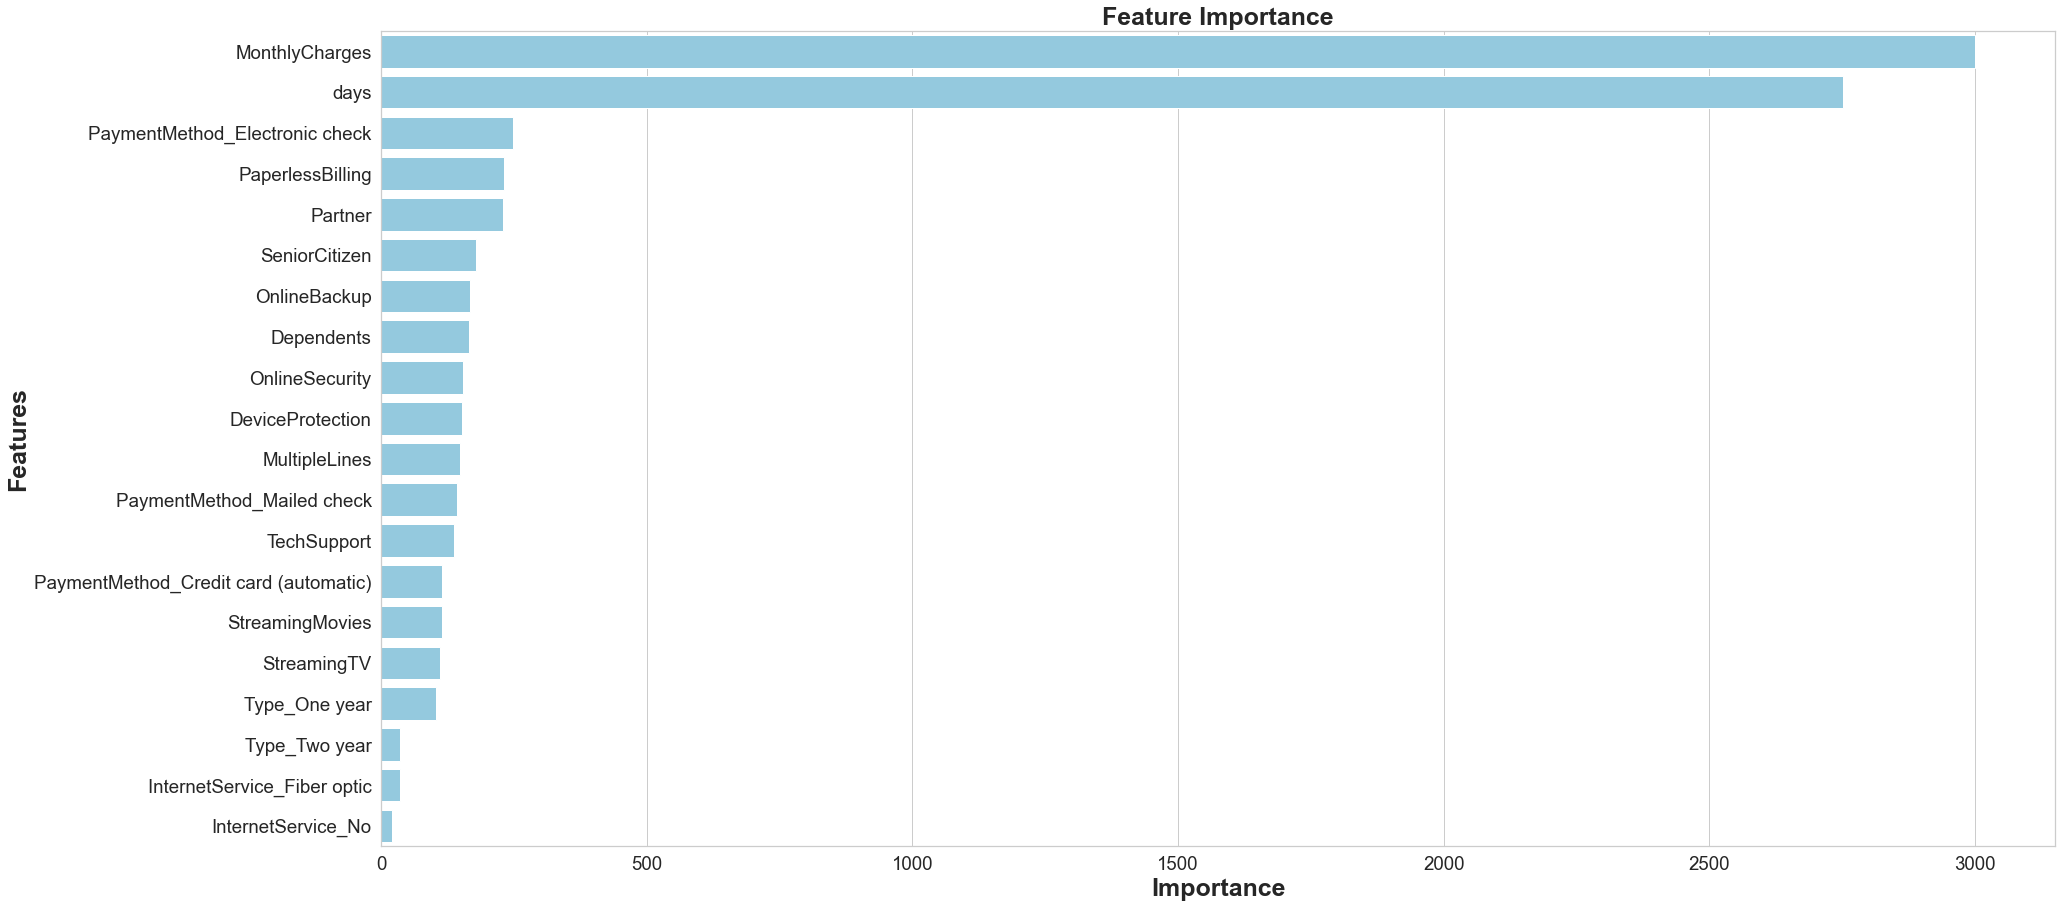

In [71]:
feats = {}
for feature, importance in zip(features.columns, best_model_LGBMClassifier.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
plt.show()

Из данного графика видим, что наверху у нас присутствуют самые важные метрики для предсказания модели.
Можно поиграться с удалением менее важных метрик из обучающего датасета и смотреть на изменение метрики ROC-AUC.

Построим ROC-кривые для всех моделей.

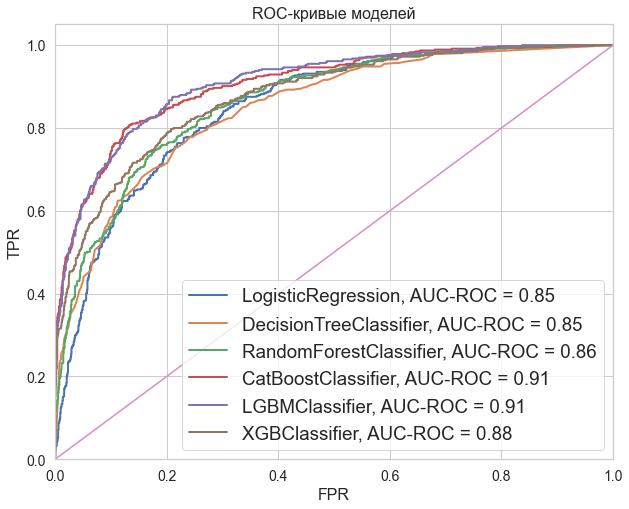

In [72]:
fpr1, tpr1, thresholds1 = roc_curve(target_test_lr, best_model_LogisticRegression.predict_proba(features_test_lr)[:,1],\
                                    pos_label=1)
fpr2, tpr2, thresholds2 = roc_curve(target_test, best_model_DecisionTreeClassifier.predict_proba(features_test)\
                                    [:,1], pos_label=1)
fpr3, tpr3, thresholds3 = roc_curve(target_test, best_model_RandomForestClassifier.predict_proba\
                                    (features_test)[:,1], pos_label=1)
fpr4, tpr4, thresholds3 = roc_curve(target_test, best_model_CatBoostClassifier.predict_proba\
                                    (features_test)[:,1], pos_label=1)
fpr5, tpr5, thresholds3 = roc_curve(target_test_lgbm, best_model_LGBMClassifier.predict_proba\
                                    (features_test_lgbm)[:,1], pos_label=1)
fpr6, tpr6, thresholds3 = roc_curve(target_test, best_model_XGBClassifier.predict_proba\
                                    (features_test)[:,1], pos_label=1)

auc_LogisticRegression = roc_auc_score(target_test_lr, best_model_LogisticRegression.predict_proba\
                                       (features_test_lr)[:,1])
auc_DecisionTreeClassifier = roc_auc_score(target_test, best_model_DecisionTreeClassifier.predict_proba\
                                           (features_test)[:,1])
auc_RandomForestClassifier = roc_auc_score(target_test, best_model_RandomForestClassifier.predict_proba\
                                           (features_test)[:,1])
auc_CatBoostClassifier = roc_auc_score(target_test, best_model_CatBoostClassifier.predict_proba\
                                       (features_test)[:,1])
auc_LGBMClassifier = roc_auc_score(target_test_lgbm, best_model_LGBMClassifier.predict_proba\
                                   (features_test_lgbm)[:,1])
auc_XGBClassifier = roc_auc_score(target_test, best_model_XGBClassifier.predict_proba(features_test)[:,1])

lw=2
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(fpr1, tpr1, lw=lw, label= 'LogisticRegression, AUC-ROC = %.2f' %auc_LogisticRegression)
ax.plot(fpr2, tpr2, lw=lw, label= 'DecisionTreeClassifier, AUC-ROC = %.2f' %auc_DecisionTreeClassifier)
ax.plot(fpr3, tpr3, lw=lw, label= 'RandomForestClassifier, AUC-ROC = %.2f' %auc_RandomForestClassifier)
ax.plot(fpr4, tpr4, lw=lw, label= 'CatBoostClassifier, AUC-ROC = %.2f' %auc_CatBoostClassifier)
ax.plot(fpr5, tpr5, lw=lw, label= 'LGBMClassifier, AUC-ROC = %.2f' %auc_LGBMClassifier)
ax.plot(fpr6, tpr6, lw=lw, label= 'XGBClassifier, AUC-ROC = %.2f' %auc_XGBClassifier)

plt.title('ROC-кривые моделей', fontsize=16)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1])
plt.xlim([0.0, 1.0])
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.ylim([0.0, 1.05])
plt.tick_params(which='major', labelsize=14)
plt.show()

По метрике AUC-ROC лидирует CatBoostClassifier и LGBMClassifier. Но метрика Accuracy более понятна бизнесу. А вот она как-раз выше у LGBMClassifier. Важно посмотреть на матрицу ошибок.

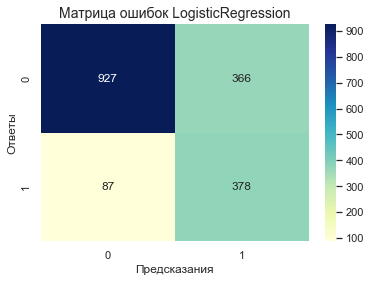

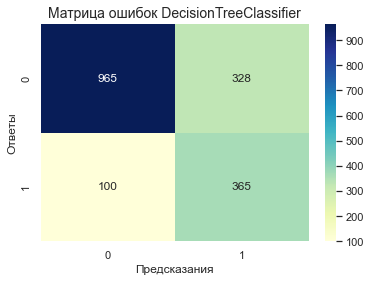

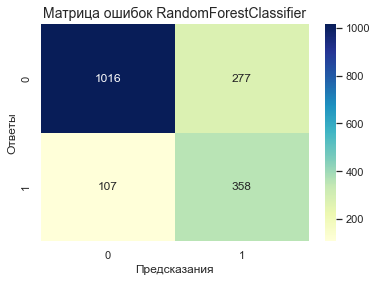

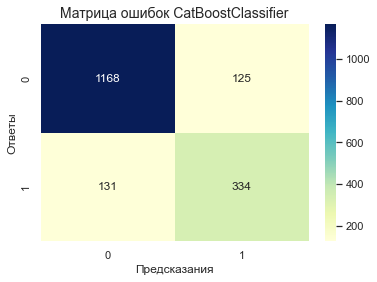

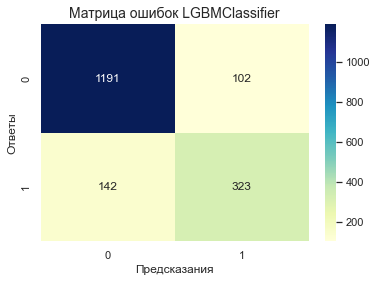

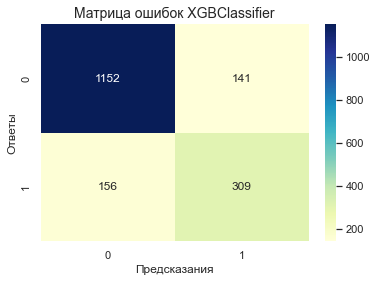

In [73]:
df_cm_LogisticRegression = pd.DataFrame(confusion_matrix(target_test_lr, best_model_LogisticRegression.predict\
                                                         (features_test_lr)))
df_cm_DecisionTreeClassifier = pd.DataFrame(confusion_matrix(target_test, best_model_DecisionTreeClassifier.\
                                                             predict(features_test)))
df_cm_RandomForestClassifier = pd.DataFrame(confusion_matrix(target_test, best_model_RandomForestClassifier.\
                                                             predict(features_test)))
df_cm_CatBoostClassifier = pd.DataFrame(confusion_matrix(target_test, best_model_CatBoostClassifier.predict\
                                                         (features_test)))
df_cm_LGBMClassifier = pd.DataFrame(confusion_matrix(target_test_lgbm, best_model_LGBMClassifier.predict\
                                                     (features_test_lgbm)))
df_cm_XGBClassifier = pd.DataFrame(confusion_matrix(target_test, best_model_XGBClassifier.predict(features_test)))

df_list = [df_cm_LogisticRegression, df_cm_DecisionTreeClassifier, df_cm_RandomForestClassifier,\
           df_cm_CatBoostClassifier, df_cm_LGBMClassifier, df_cm_XGBClassifier]
df_list_name = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'CatBoostClassifier',\
                'LGBMClassifier', 'XGBClassifier']
sns.set(font_scale=1)

for df, df_name in zip(df_list, df_list_name):
    sns.heatmap(df, annot=True, cmap='YlGnBu', fmt='d', annot_kws={'fontsize':12})
    plt.title('Матрица ошибок ' + df_name, fontsize=14)
    plt.xlabel('Предсказания', fontsize=12)
    plt.ylabel('Ответы', fontsize=12)
    plt.show()

По итогам обучения моделей можно сказать следующее:

Линейные и деревянные модели хуже других справляются с задачей. AUC-ROC неплохой (0.85-0.86), но точность и полнота хуже. На матрице ошибок видно, что модели уходят в True Negative, а значит, не упускают уходящих клиентов;

XGBClassifier приближается к CatBoostClassifier и LGBMClassifier, AUC-ROC равен 0.88, точность и полнота немного выше предыдущих моделей. Модель уже не сваливается в присвоении True Positive.

LGBMClassifier показывет хорошую метрику (0.91). Точность, полнота и accuracy самые высокие. Модель намного точнее предсказывает действительно уходящих клиентов. И что самое хорошее - не переусердствует с False Negative, то есть, упускает меньше уходящих клиентов, при этом не переприсваивая False Positive.

Финальная таблица без сюрпризов. Лучшая модель по совокупности всех метрик - LGBMClassifier. Но у нее есть свои недостатки: склонность к переобучению и самое долгое время предсказания из рассматриваемых.

<a id=step_4></a>
## 4. Вывод о проделанной работе и рекомендации заказчику

Подитожим: заказчику можно рекомендовать модель LGBMClassifier. Она дает неплохие метрики, но долгая по времени предсказания и может свалится к переобучению.

При рекомендации модели заказчику принималось во внимание, что нам необходимо соблюсти баланс между минимальным FP (чтобы не потратить бюджет на клиентов, которые не собирались уходить), FN (чтобы не упустить действительно уходящих), а также временем предсказания модели.

Также необходимо отметить, что в процессе проработки данного проекта выявился портрет пользователя, который склонен прервать контракт:

это абонент, не состоящий в браке, не имеющий иждивенцев (детей, престарелых родителей, инвалидов), не достигший пенсионного возраста, заключивший договор недавно, оплачивающий услуги с безналичной оплатой электронными чеками помесячно, имеющий подключение по оптоволоконной связи и не подключающий услуги онлайн-защиты, не пользующийся предлагаемыми дополнительными услугами связи.

Необходимо над этим поработать.

В результате можно резюмировать:

Ранее намеченный план действий послностью себя оправдал. Единственное, что пришлось сделать, это поиграться в фич-инжиниринг и побороться с дисбалансом классов (хотя были предпосылки не вступать в эту борьбу - как показала себя модель LGBMClassifier), но пришлось бы играться больше с удалением либо генерацией новых фич.